# Results of Device Collection, Data Collection, Labeling, Feature Extraction and Data Splitting

In [7]:
!pip install prettytable

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from prettytable import PrettyTable

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.metrics import classification_report, accuracy_score

In [10]:
input_csv_file = 'csv 20 minutes/labeled2/features_final/together/all_data_final.csv'
df = pd.read_csv(input_csv_file, delimiter=';', error_bad_lines=False, encoding='ISO-8859-1')

## DEVICE COLLECTION & DATA COLLECTION & LABELING

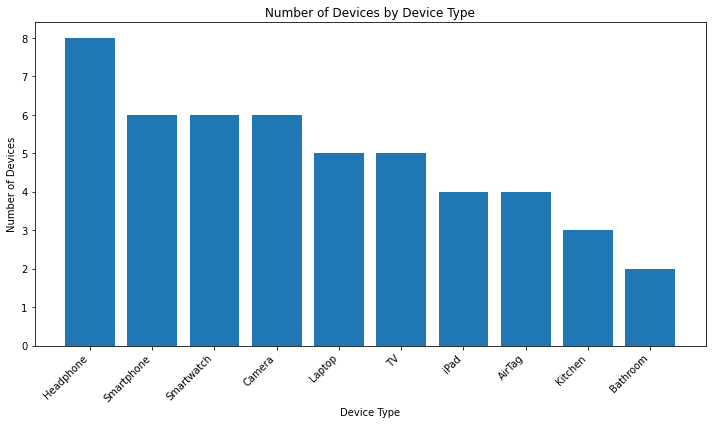

In [11]:
# Plot the number of device types
device_counts = {
    "Headphone": 8,
    "Smartphone": 6,
    "Smartwatch": 6,
    "Camera": 6,
    "Laptop": 5,
    "TV": 5,
    "iPad": 4,
    "AirTag": 4,
    "Kitchen": 3,
    "Bathroom": 2
}

plt.figure(figsize=(10, 6))
plt.bar(device_counts.keys(), device_counts.values())
plt.title('Number of Devices by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Number of Devices')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
save_path = "Diagrams/device_collection_distribution.png"
plt.savefig(save_path, bbox_inches='tight')
plt.show()

In [12]:
# Get the number of packets for each device type
device_type_counts = df['label'].value_counts()

# Filter out device types with less than 100 packets
device_types_to_keep = device_type_counts[device_type_counts >= 10000].index
filtered_df = df[df['label'].isin(device_types_to_keep)]
filtered_device_type_counts = filtered_df['label'].value_counts()
sorted_filtered_device_types = filtered_device_type_counts.sort_values(ascending=False)
i = 1
for device_type, count in sorted_filtered_device_types.items():
    print(f"{i}. {device_type}: {count} packets")
    i = i + 1

1. Headphone: 144688 packets
2. Bathroom: 130805 packets
3. Camera: 130607 packets
4. Laptop: 127793 packets
5. Smartwatch: 108582 packets
6. Smartphone: 102050 packets
7. iPad: 74453 packets
8. Kitchen: 38240 packets
9. TV: 28124 packets
10. AirTag: 16281 packets


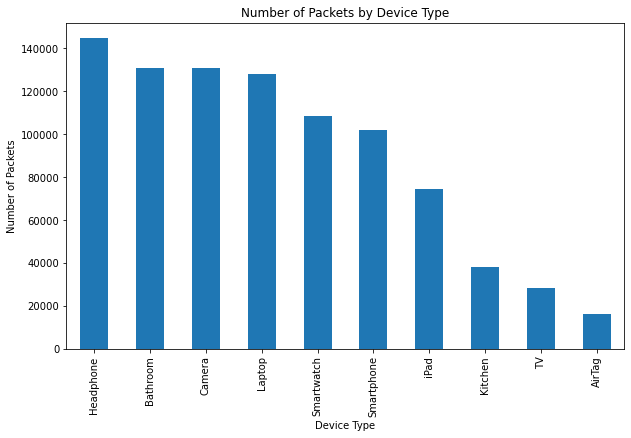

In [13]:
# Plot the number of packets for device types
plt.figure(figsize=(10, 6))
filtered_device_type_counts.plot(kind='bar')
plt.title('Number of Packets by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Number of Packets')
save_path = "Diagrams/Number of Packets by Device Type.png"
plt.show()

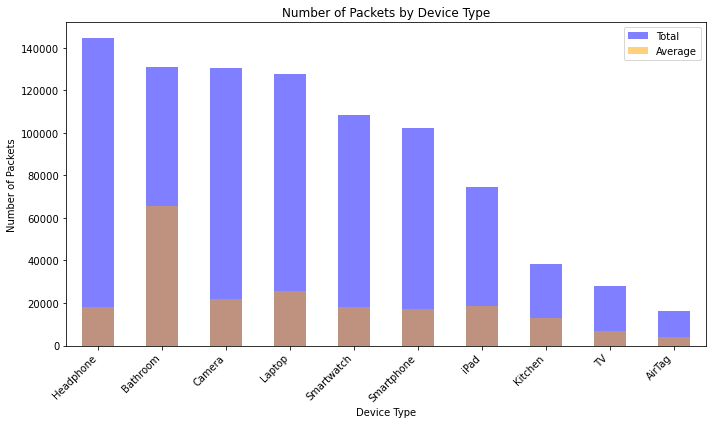

In [14]:
# Plot total and average number of packets per device type
adjusted_counts = filtered_device_type_counts.copy()
adjustments = {'Headphone': 8, 'Smartphone': 6, 'Smartwatch': 6, 'Laptop': 5, 'iPad': 4, 'AirTag': 4, 'TV': 4, 'Kitchen': 3,
               'Camera': 6, 'Bathroom': 2}

for device_type, divisor in adjustments.items():
    if device_type in adjusted_counts:
        adjusted_counts[device_type] /= divisor

# Plot the original and adjusted bar diagrams
fig, ax = plt.subplots(figsize=(10, 6))
filtered_device_type_counts.plot(kind='bar', alpha=0.5, color='blue', label='Total', ax=ax)
adjusted_counts.plot(kind='bar', alpha=0.5, color='orange', label='Average', ax=ax)
plt.title('Number of Packets by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Number of Packets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend()
save_path = "Diagrams/Number of Packets by Device Type 2.png"
plt.savefig(save_path, bbox_inches='tight')
plt.show()

In [15]:
print(filtered_device_type_counts)

Headphone     144688
Bathroom      130805
Camera        130607
Laptop        127793
Smartwatch    108582
Smartphone    102050
iPad           74453
Kitchen        38240
TV             28124
AirTag         16281
Name: label, dtype: int64


In [16]:
print(adjusted_counts)

Headphone     18086.000000
Bathroom      65402.500000
Camera        21767.833333
Laptop        25558.600000
Smartwatch    18097.000000
Smartphone    17008.333333
iPad          18613.250000
Kitchen       12746.666667
TV             7031.000000
AirTag         4070.250000
Name: label, dtype: float64


Device Type: AirTag
 - Subcategory: 4x Apple Airtag | Packet Count: 16281
Device Type: Bathroom
 - Subcategory: AquaClean Shower Toilet | Packet Count: 1044
 - Subcategory: Toothbrush | Packet Count: 129761
Device Type: Camera
 - Subcategory: Canon | Packet Count: 41003
 - Subcategory: GoPro10 | Packet Count: 14196
 - Subcategory: GoPro4 | Packet Count: 7096
 - Subcategory: GoPro5 | Packet Count: 7774
 - Subcategory: GoPro9 | Packet Count: 16162
 - Subcategory: Rollei Camera | Packet Count: 44376
Device Type: Headphone
 - Subcategory: Apple Headphone | Packet Count: 43456
 - Subcategory: Beats Headphone | Packet Count: 16
 - Subcategory: Bose-1 Headphone | Packet Count: 3319
 - Subcategory: Bose-2 Headphone | Packet Count: 4552
 - Subcategory: Samsung Headphone | Packet Count: 1811
 - Subcategory: Sony Linkbuds Headphone | Packet Count: 43111
 - Subcategory: Sony XM3 Headphone | Packet Count: 15088
 - Subcategory: Sony XM4 Headphone | Packet Count: 33335
Device Type: Kitchen
 - Subcate

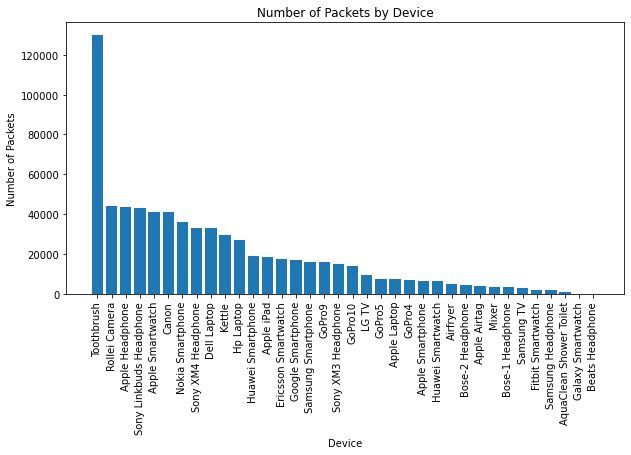

In [17]:
# Plot the number of packets per device
device_subcategory_counts = filtered_df.groupby(['label', 'subcategory']).size().reset_index(name='packet_count')
unique_device_types = device_subcategory_counts['label'].unique()
my_dict = {}
for device_type in unique_device_types:
    print("Device Type:", device_type)
    subcategories = device_subcategory_counts[device_subcategory_counts['label'] == device_type]
    for index, row in subcategories.iterrows():
        if row['subcategory'] == 'Apple Airtag':
            print(" - Subcategory: 4x", row['subcategory'], "| Packet Count:", row['packet_count'])
            row['packet_count'] = row['packet_count'] / 4
        elif row['subcategory'] == 'Dell Laptop':
            print(" - Subcategory: 2x", row['subcategory'], "| Packet Count:", row['packet_count'])
            row['packet_count'] = row['packet_count'] / 2
        elif row['subcategory'] == 'Hp Laptop':
            print(" - Subcategory: 2x", row['subcategory'], "| Packet Count:", row['packet_count'])
            row['packet_count'] = row['packet_count'] / 2
        elif row['subcategory'] == 'Apple Smartphone':
            print(" - Subcategory: 2x", row['subcategory'], "| Packet Count:", row['packet_count'])
            row['packet_count'] = row['packet_count'] / 2
        elif row['subcategory'] == 'Apple Smartwatch':
            print(" - Subcategory: 2x", row['subcategory'], "| Packet Count:", row['packet_count'])
            row['packet_count'] = row['packet_count'] / 2
        elif row['subcategory'] == 'LG TV':
            print(" - Subcategory: 2x", row['subcategory'], "| Packet Count:", row['packet_count'])
            row['packet_count'] = row['packet_count'] / 2
        elif row['subcategory'] == 'Samsung TV':
            print(" - Subcategory: 3x", row['subcategory'], "| Packet Count:", row['packet_count'])
            row['packet_count'] = row['packet_count'] / 3
        elif row['subcategory'] == 'Apple iPad':
            print(" - Subcategory: 4x", row['subcategory'], "| Packet Count:", row['packet_count'])
            row['packet_count'] = row['packet_count'] / 4
        else:
            print(" - Subcategory:", row['subcategory'], "| Packet Count:", row['packet_count'])
        my_dict[row['subcategory']] = row['packet_count']

sorted_dict = dict(sorted(my_dict.items(), key=lambda item: item[1], reverse=True))
print(sorted_dict)
subcategory = list(sorted_dict.keys())
nr_packets = list(sorted_dict.values())

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(subcategory, nr_packets)
plt.title('Number of Packets by Device')
plt.xlabel('Device')
plt.ylabel('Number of Packets')
plt.xticks(rotation=90)
plt.show()

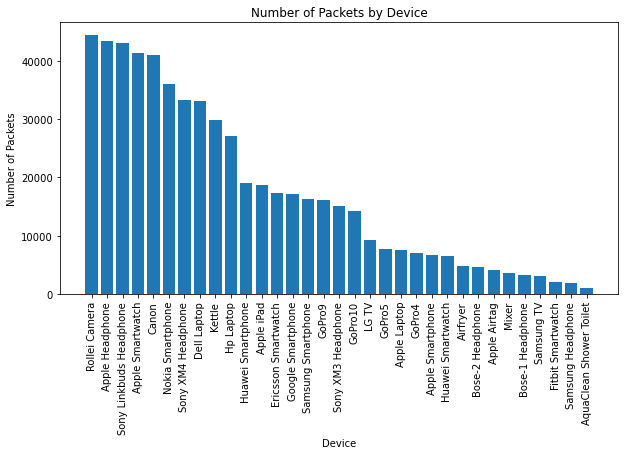

In [18]:
# Remove toothbrush, galaxy smartwatch and beats headphones
if 'Toothbrush' in sorted_dict:
    sorted_dict.pop('Toothbrush')
if 'Galaxy Smartwatch' in sorted_dict:
    sorted_dict.pop('Galaxy Smartwatch')
if 'Beats Headphone' in sorted_dict:
    sorted_dict.pop('Beats Headphone')

subcategory = list(sorted_dict.keys())
nr_packets = list(sorted_dict.values())

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(subcategory, nr_packets)
plt.title('Number of Packets by Device')
plt.xlabel('Device')
plt.ylabel('Number of Packets')
plt.xticks(rotation=90)
save_path = "Diagrams/Number of Packets by Device (no Toothbrush).png"
plt.savefig(save_path, bbox_inches='tight')
plt.show()

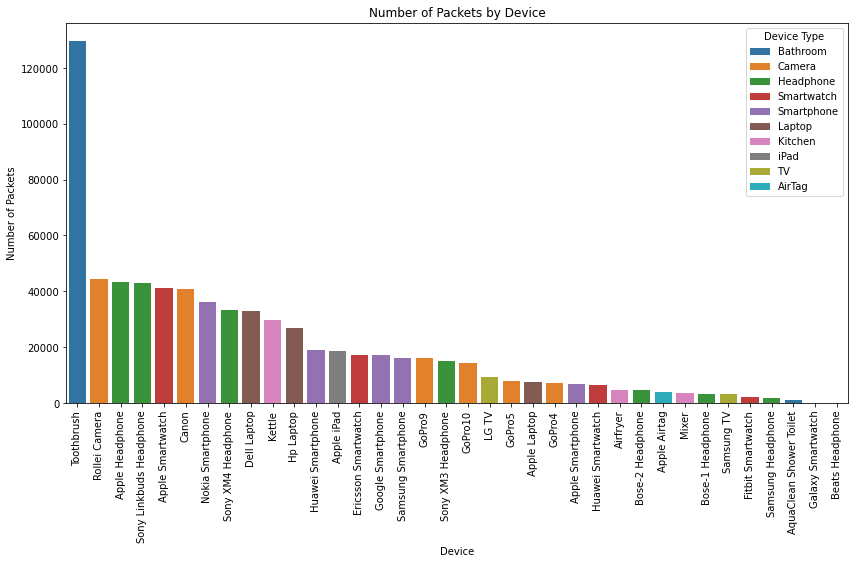

In [19]:
# Plot the number of packets per device with different colours which indicates the device type
device_subcategory_counts = filtered_df.groupby(['label', 'subcategory']).size().reset_index(name='packet_count')
device_subcategory_counts['adjusted_packet_count'] = device_subcategory_counts['packet_count']
adjustments = {
    'Apple Airtag': 4,
    'Dell Laptop': 2,
    'Hp Laptop': 2,
    'Apple Smartphone': 2,
    'Apple Smartwatch': 2,
    'LG TV': 2,
    'Samsung TV': 3,
    'Apple iPad': 4
}
for subcategory, factor in adjustments.items():
    device_subcategory_counts.loc[device_subcategory_counts['subcategory'] == subcategory, 'adjusted_packet_count'] /= factor
sorted_data = device_subcategory_counts.sort_values(by='adjusted_packet_count', ascending=False)

# Plotting
plt.figure(figsize=(14, 7))
sns.barplot(data=sorted_data, x='subcategory', y='adjusted_packet_count', hue='label', dodge=False)
plt.title('Number of Packets by Device')
plt.xlabel('Device')
plt.ylabel('Number of Packets')
plt.xticks(rotation=90)
plt.legend(title='Device Type')
save_path = "Diagrams/Number of Packets by Device with Labels.png"
plt.savefig(save_path, bbox_inches='tight')
plt.show()

In [20]:
print(sorted_data)

         label              subcategory  packet_count  adjusted_packet_count
2     Bathroom               Toothbrush        129761          129761.000000
8       Camera            Rollei Camera         44376           44376.000000
9    Headphone          Apple Headphone         43456           43456.000000
14   Headphone  Sony Linkbuds Headphone         43111           43111.000000
28  Smartwatch         Apple Smartwatch         82528           41264.000000
3       Camera                    Canon         41003           41003.000000
26  Smartphone         Nokia Smartphone         36086           36086.000000
16   Headphone       Sony XM4 Headphone         33335           33335.000000
21      Laptop              Dell Laptop         66187           33093.500000
18     Kitchen                   Kettle         29756           29756.000000
22      Laptop                Hp Laptop         54045           27022.500000
25  Smartphone        Huawei Smartphone         19073           19073.000000

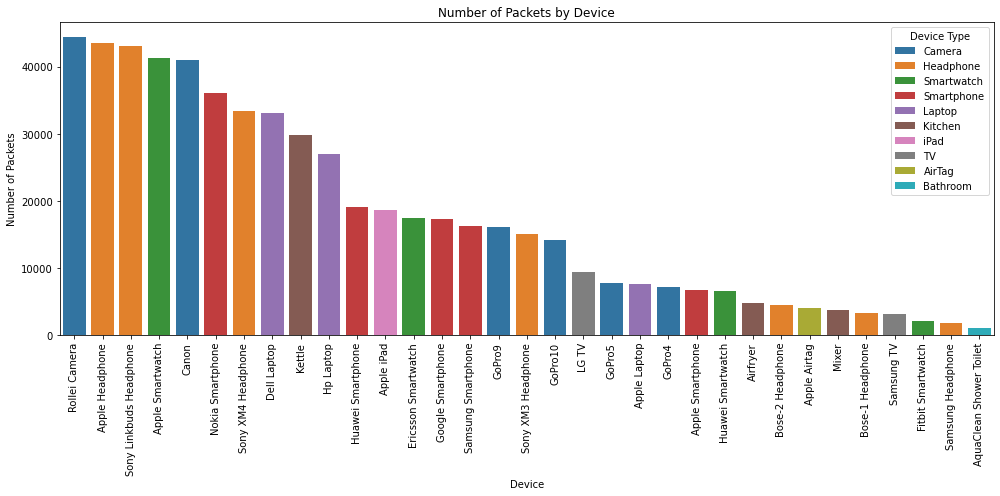

In [21]:
# Remove toothbrush, galaxy smartwatch and beats heaphone
subcategories_to_remove = ['Toothbrush', 'Galaxy Smartwatch', 'Beats Headphone']
filtered_data = sorted_data[~device_subcategory_counts['subcategory'].isin(subcategories_to_remove)]

# Plotting
plt.figure(figsize=(14, 7))
sns.barplot(data=filtered_data, x='subcategory', y='adjusted_packet_count', hue='label', dodge=False)
plt.title('Number of Packets by Device')
plt.xlabel('Device')
plt.ylabel('Number of Packets')
plt.xticks(rotation=90)
plt.legend(title='Device Type')
plt.tight_layout()
save_path = "Diagrams/Number of Packets by Device with Labels (no Toothbrush).png"
plt.savefig(save_path, bbox_inches='tight')
plt.show()

## DIRECT FEATURE EXTRACTION

In [23]:
# function which plots for each feature a bar chart: y axis is the number of packets and x axis is the feature
def plot_direct_features(input_csv_file, filtering_size, feature, name, save_path=None, lowercase=None, toothbrush=None, rounding=None, power_level=None, rotating=90):
    df = pd.read_csv(input_csv_file, delimiter=';', error_bad_lines=False, encoding='ISO-8859-1')

    # Convert feature values to lowercase
    if lowercase:
        df[feature] = df[feature].str.lower()
        
    # Remove OralB Toothbrush data if 'toothbrush' is True
    if toothbrush:
        df = df[df['subcategory'] != 'Toothbrush']

    # Filter out data with less than the 'filtering_size' value
    filtered_df = df[df.groupby(feature)[feature].transform('size') >= filtering_size]
    
    # Normalize the values to combine similar x-values
    def normalize_value(x):
        if isinstance(x, str):
            match = re.match(r"(-?\d+(\.\d+)?)[ ]*dBm", x)
            if match:
                return round(float(match.group(1)), 3)
        try:
            return round(float(x), 3)
        except ValueError:
            return x

    filtered_df[feature] = filtered_df[feature].apply(normalize_value)
    
    # Group by the given feature and "label" columns
    grouped_df = filtered_df.groupby([feature, 'label']).size().unstack(fill_value=0)
    
    # Round the values to 3 decimal if 'rounding' is True
    if rounding:
        grouped_df.index = np.round(grouped_df.index.values, 3)

    # Get different colors for each device type
    labels = grouped_df.columns
    colors = plt.cm.get_cmap('tab10', len(labels))

    x_values = grouped_df.index.tolist()
    bar_width = 0.35

    # Plot each label with a different color
    plt.figure(figsize=(12, 6))
    bars = None
    bottom = np.zeros(len(x_values))
    for i, label in enumerate(labels):
        label_data = grouped_df[label]
        # Print only non-zero values
        non_zero_values = label_data[label_data > 0]
        if not non_zero_values.empty:
            print(non_zero_values)
        bars = plt.bar(np.arange(len(x_values)), label_data, color=colors(i), label=label, bottom=bottom)
        bottom += label_data

    plt.title(f"Number of Packets by {name}")
    plt.xlabel(name)
    plt.ylabel('Number of Packets')
    
    if len(x_values) > 40:
        tick_spacing = len(x_values) // 40 + 1
    else:
        tick_spacing = 1
        
    def format_xtick(x):
        try:
            x = float(x)
            return f'{int(x)}' if x.is_integer() else f'{x:.3f}'
        except ValueError:
            return str(x)
    formatted_x_values = [format_xtick(x) for x in x_values]
    
    if rounding:
        plt.xticks(np.arange(0, len(x_values), tick_spacing), [format_xtick(x) for x in x_values[::tick_spacing]], rotation=rotating)
    else:
        plt.xticks(np.arange(0, len(x_values), tick_spacing), [format_xtick(x) for x in x_values[::tick_spacing]], rotation=rotating)
    plt.legend(title='Device Type')

    y_max = bottom.max()
    plt.ylim(0, y_max * 1.1)

    # Save the plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

Length of payload
25.0      82
31.0     112
33.0     704
36.0       2
39.0       2
40.0       3
41.0       4
42.0    3787
43.0    1965
44.0    2368
45.0       2
46.0       3
47.0       1
48.0       2
49.0       2
50.0       2
52.0     123
56.0    7084
Name: AirTag, dtype: int64
Length of payload
31.0      7888
36.0         4
37.0         1
38.0         5
39.0         3
40.0         8
41.0        14
42.0       680
43.0    114967
44.0         1
50.0         2
53.0      7189
55.0         5
56.0         1
Name: Bathroom, dtype: int64
Length of payload
29.0        2
31.0    10374
33.0        5
39.0        3
40.0        2
41.0     2222
42.0     3633
47.0        3
48.0    41161
49.0      253
50.0        1
52.0    39852
53.0        6
54.0        1
56.0    33039
Name: Camera, dtype: int64
Length of payload
25.0      357
30.0        1
31.0     1583
33.0       17
37.0        1
38.0       70
39.0     4399
40.0    16491
42.0       23
43.0       51
44.0        7
45.0    30267
46.0    19797
47.0     

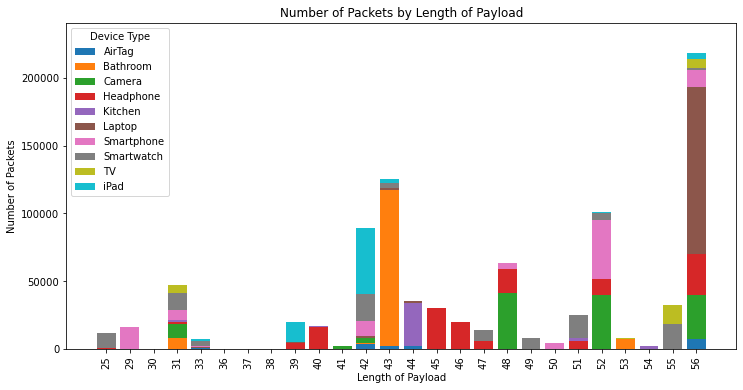

In [24]:
save_path = "Diagrams/Number of Packets by Length of Payload.png"
plot_direct_features(input_csv_file, 50, 'Length of payload', 'Length of Payload', save_path)

Channel Index
37.0    5400
38.0    5418
39.0    5463
Name: AirTag, dtype: int64
Channel Index
37.0    39380
38.0    45259
39.0    46166
Name: Bathroom, dtype: int64
Channel Index
37.0    36054
38.0    44277
39.0    50276
Name: Camera, dtype: int64
Channel Index
37.0    47198
38.0    48255
39.0    49235
Name: Headphone, dtype: int64
Channel Index
37.0     9745
38.0    14048
39.0    14447
Name: Kitchen, dtype: int64
Channel Index
37.0    42507
38.0    42627
39.0    42659
Name: Laptop, dtype: int64
Channel Index
37.0    31208
38.0    37052
39.0    33790
Name: Smartphone, dtype: int64
Channel Index
37.0    36693
38.0    36553
39.0    35336
Name: Smartwatch, dtype: int64
Channel Index
37.0    12846
38.0     6420
39.0     8858
Name: TV, dtype: int64
Channel Index
37.0    28129
38.0    23172
39.0    23152
Name: iPad, dtype: int64


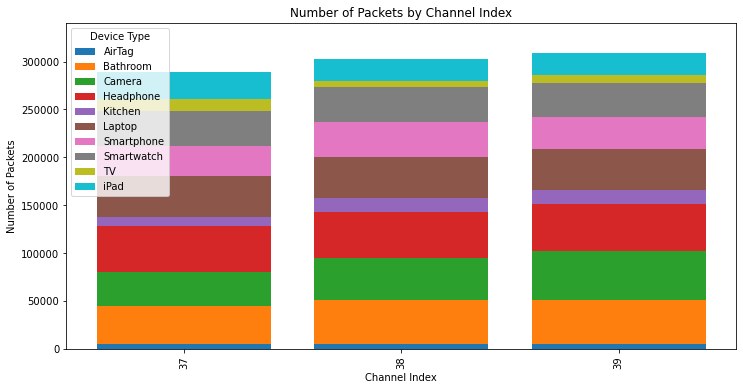

In [25]:
save_path = "Diagrams/Number of Packets by Channel Index.png"
plot_direct_features(input_csv_file, 0, 'Channel Index', 'Channel Index', save_path)

RSSI
-93.0     30
-92.0     48
-91.0    120
-90.0    233
-89.0    332
        ... 
-33.0    463
-32.0    965
-31.0      2
-30.0      5
-28.0      1
Name: AirTag, Length: 65, dtype: int64
RSSI
-93.0     28
-92.0     54
-91.0    122
-90.0    189
-89.0    189
        ... 
-33.0    343
-32.0    210
-31.0     87
-30.0     35
-29.0    113
Name: Bathroom, Length: 65, dtype: int64
RSSI
-93.0      6
-92.0     40
-91.0     81
-90.0    166
-89.0    332
        ... 
-29.0      5
-28.0     37
-27.0    765
-26.0    641
-25.0      6
Name: Camera, Length: 69, dtype: int64
RSSI
-93.0      2
-92.0      8
-91.0      5
-90.0     16
-89.0     26
        ... 
-21.0    542
-20.0     86
-19.0     77
-18.0    134
-17.0     19
Name: Headphone, Length: 77, dtype: int64
RSSI
-92.0     1
-91.0     5
-90.0    11
-89.0    13
-88.0    14
         ..
-24.0    14
-23.0    27
-22.0     8
-21.0    20
-20.0     8
Name: Kitchen, Length: 73, dtype: int64
RSSI
-93.0        9
-92.0       15
-91.0       38
-90.0       77
-89.0

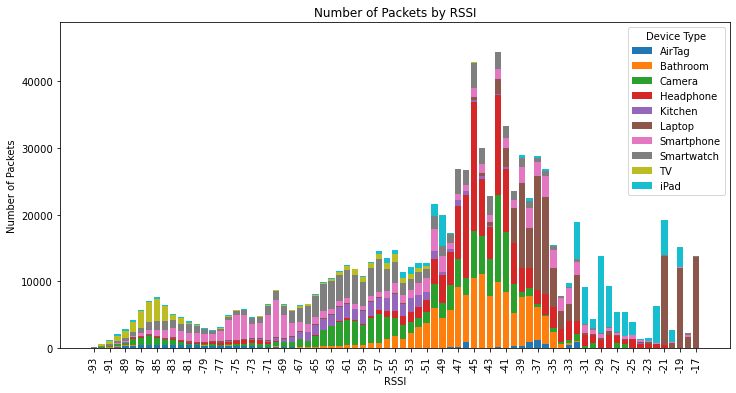

In [26]:
save_path = "Diagrams/Number of Packets by RSSI.png"
plot_direct_features(input_csv_file, 100, 'RSSI', 'RSSI', save_path)

RSSI
-63.0      66
-62.0      78
-61.0      64
-60.0      52
-59.0      25
-58.0      32
-57.0      21
-56.0      20
-55.0       9
-54.0      10
-53.0       4
-52.0       6
-51.0      14
-50.0       6
-49.0       8
-48.0     146
-47.0     275
-46.0     931
-45.0      52
-44.0      12
-43.0       4
-42.0     155
-41.0      27
-40.0     310
-39.0     437
-38.0     982
-37.0    1222
-36.0     699
-35.0      10
-32.0     965
Name: AirTag, dtype: int64
RSSI
-63.0      232
-62.0      298
-61.0      459
-60.0      390
-59.0      442
-58.0      708
-57.0      843
-56.0     1344
-55.0     1862
-54.0     1467
-53.0     2293
-52.0     3226
-51.0     3730
-50.0     6033
-49.0     4508
-48.0     5642
-47.0     8861
-46.0     7007
-45.0    10513
-44.0    11102
-43.0     7765
-42.0     9832
-41.0     8346
-40.0     4918
-39.0     7226
-38.0     6906
-37.0     5001
-36.0     4107
-35.0     2500
-32.0      210
-29.0      113
Name: Bathroom, dtype: int64
RSSI
-63.0     3030
-62.0     3536
-61.0     3785

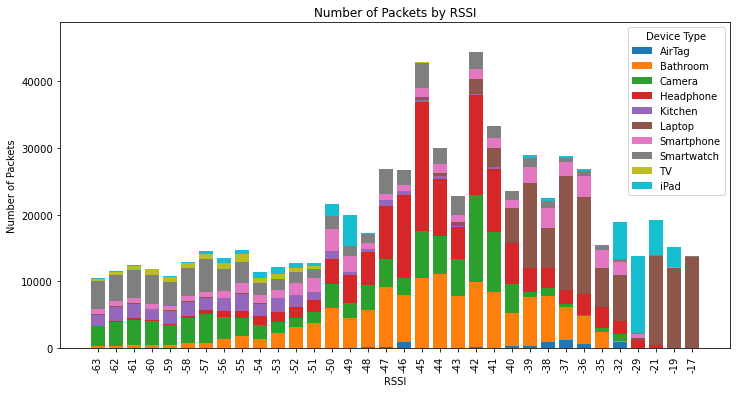

In [27]:
save_path = "Diagrams/Number of Packets by RSSI2.png"
plot_direct_features(input_csv_file, 10000, 'RSSI', 'RSSI', save_path)

Delta time ( end to start)
132.0     812
150.0      89
151.0      74
366.0     748
367.0     100
368.0    2261
Name: AirTag, dtype: int64
Delta time ( end to start)
132.0        3
150.0     6539
151.0     7826
180.0     3358
181.0     1527
188.0        1
366.0        5
367.0        2
368.0        1
384.0        1
393.0    62217
394.0     5702
455.0        2
502.0        6
Name: Bathroom, dtype: int64
Delta time ( end to start)
132.0       82
150.0     4988
151.0     9185
180.0        2
181.0        3
188.0        2
366.0     1329
367.0    14068
368.0       92
384.0        3
393.0        4
394.0        2
455.0    10414
502.0        4
Name: Camera, dtype: int64
Delta time ( end to start)
132.0       10
150.0     1542
151.0      396
180.0        1
188.0       57
366.0        8
367.0       62
368.0     1157
384.0        1
393.0     1443
394.0      131
502.0    13288
Name: Headphone, dtype: int64
Delta time ( end to start)
150.0    850
151.0    745
366.0      2
367.0      1
384.0      1
394

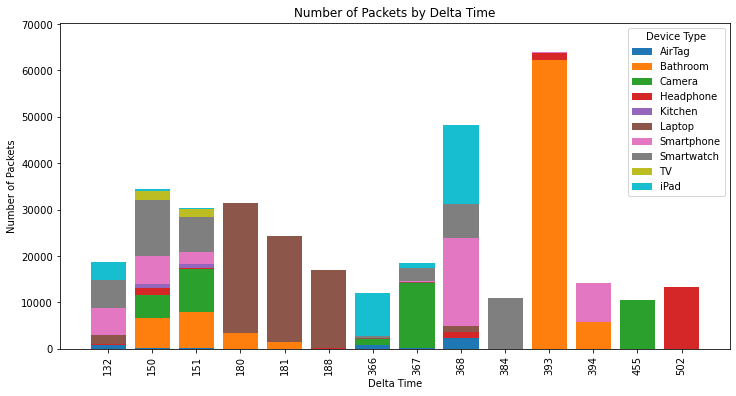

In [28]:
save_path = "Diagrams/Number of Packets by Delta time.png"
plot_direct_features(input_csv_file, 10000, 'Delta time ( end to start)', 'Delta Time', save_path)

Type
Flags,Manufacturer Specific                    702
Flags,Tx Power Level,Manufacturer Specific    7360
Manufacturer Specific                         7782
Name: AirTag, dtype: int64
Type
16-bit Service Class UUIDs          1
Flags,Manufacturer Specific    114949
Name: Bathroom, dtype: int64
Type
Flags,128-bit Service Class UUIDs,Manufacturer Specific                 33038
Flags,16-bit Service Class UUIDs (incomplete),Appearance,Device Name    39603
Flags,16-bit Service Class UUIDs (incomplete),Manufacturer Specific     41137
Name: Camera, dtype: int64
Type
16-bit Service Class UUIDs                                                                               2
16-bit Service Class UUIDs,Device Name                                                               30252
Flags,16-bit Service Class UUIDs,Device Name                                                          2878
Flags,Manufacturer Specific                                                                           7789
Flags,

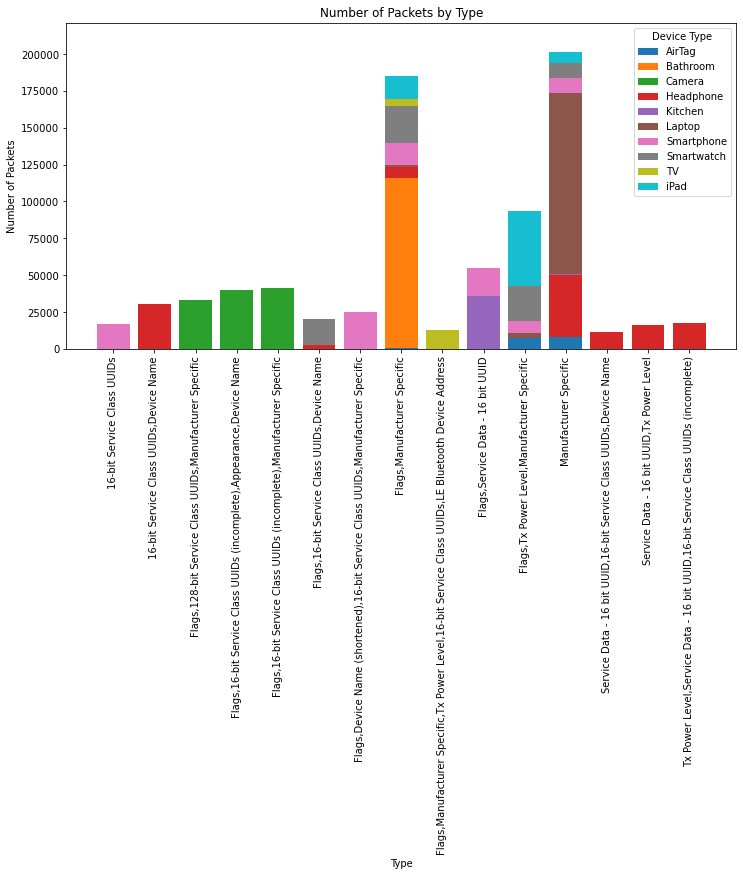

In [29]:
save_path = "Diagrams/Number of Packets by Type.png"
plot_direct_features(input_csv_file, 10000, 'Type', 'Type', save_path)

Info
ADV_IND            14098
ADV_NONCONN_IND     1775
ADV_SCAN_IND           3
SCAN_REQ             110
SCAN_RSP              87
Name: AirTag, dtype: int64
Info
ADV_IND            115414
ADV_NONCONN_IND         6
ADV_SCAN_IND            2
SCAN_REQ             7888
SCAN_RSP             7178
Name: Bathroom, dtype: int64
Info
ADV_IND         113806
ADV_SCAN_IND         1
SCAN_REQ         10431
SCAN_RSP          6106
Name: Camera, dtype: int64
Info
ADV_IND            98004
ADV_NONCONN_IND    19781
ADV_SCAN_IND       24387
SCAN_REQ            1584
SCAN_RSP             659
Name: Headphone, dtype: int64
Info
ADV_IND     35775
SCAN_REQ     1224
SCAN_RSP     1181
Name: Kitchen, dtype: int64
Info
ADV_IND              4106
ADV_NONCONN_IND    123547
ADV_SCAN_IND            1
SCAN_REQ                6
SCAN_RSP                8
Name: Laptop, dtype: int64
Info
ADV_IND            63044
ADV_NONCONN_IND     8793
ADV_SCAN_IND       16623
SCAN_REQ            7673
SCAN_RSP            5488
Name: Smartphone

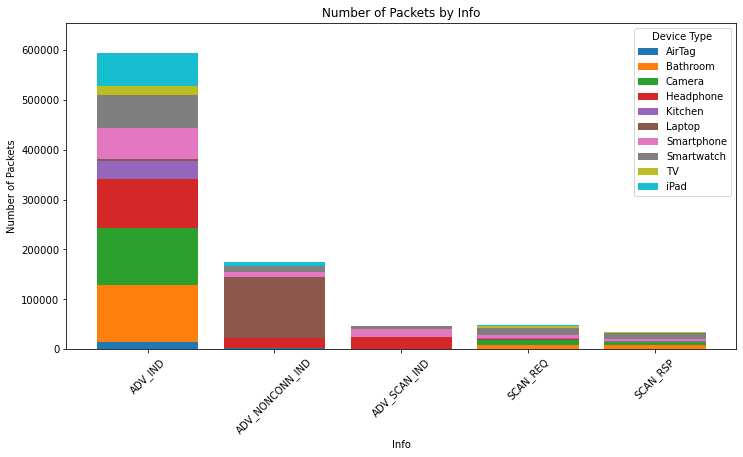

In [30]:
save_path = "Diagrams/Number of Packets by Info.png"
plot_direct_features(input_csv_file, 3500, 'Info', 'Info', save_path, rotating=45)

Reserved
0.0    16152
1.0       11
Name: AirTag, dtype: int64
Reserved
0.0    122888
1.0        13
Name: Bathroom, dtype: int64
Reserved
0.0    120005
1.0       161
Name: Camera, dtype: int64
Reserved
0.0    110119
1.0     32983
Name: Headphone, dtype: int64
Reserved
0.0    37004
1.0        1
Name: Kitchen, dtype: int64
Reserved
0.0    127774
1.0        11
Name: Laptop, dtype: int64
Reserved
0.0    94369
1.0        5
Name: Smartphone, dtype: int64
Reserved
0.0    88889
1.0     7154
Name: Smartwatch, dtype: int64
Reserved
0.0    12173
1.0    10177
Name: TV, dtype: int64
Reserved
0.0    74063
1.0       24
Name: iPad, dtype: int64


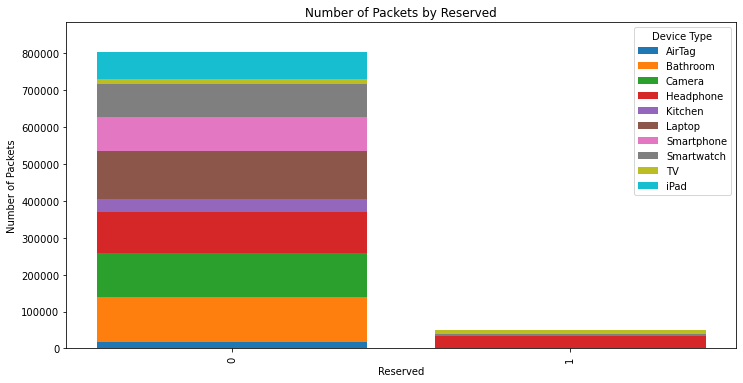

In [31]:
save_path = "Diagrams/Number of Packets by Reserved.png"
plot_direct_features(input_csv_file, 0, 'Reserved', 'Reserved', save_path)

Channel Selection Algorithm
#1    6259
#2    8024
Name: AirTag, dtype: int64
Channel Selection Algorithm
#1    115690
#2         5
Name: Bathroom, dtype: int64
Channel Selection Algorithm
#1    114065
Name: Camera, dtype: int64
Channel Selection Algorithm
#1    50711
#2    47512
Name: Headphone, dtype: int64
Channel Selection Algorithm
#1    35835
Name: Kitchen, dtype: int64
Channel Selection Algorithm
#1    3630
#2     565
Name: Laptop, dtype: int64
Channel Selection Algorithm
#1    52001
#2    11457
Name: Smartphone, dtype: int64
Channel Selection Algorithm
#1    37412
#2    28950
Name: Smartwatch, dtype: int64
Channel Selection Algorithm
#1    10832
#2     8945
Name: TV, dtype: int64
Channel Selection Algorithm
#1    59747
#2     6712
Name: iPad, dtype: int64


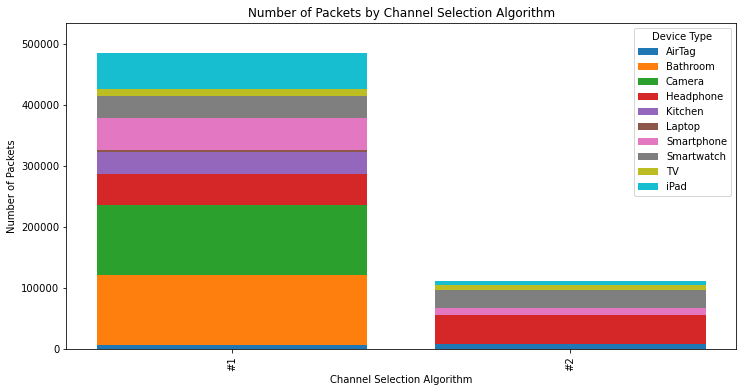

In [32]:
save_path = "Diagrams/Number of Packets by Channel Selection Algorithm.png"
plot_direct_features(input_csv_file, 0, 'Channel Selection Algorithm', 'Channel Selection Algorithm', save_path)

Tx Address
Public       10
Random    16271
Name: AirTag, dtype: int64
Tx Address
Public    122908
Random      7897
Name: Bathroom, dtype: int64
Tx Address
Public    86459
Random    44148
Name: Camera, dtype: int64
Tx Address
Public     38233
Random    106455
Name: Headphone, dtype: int64
Tx Address
Public    37823
Random      417
Name: Kitchen, dtype: int64
Tx Address
Public         7
Random    127786
Name: Laptop, dtype: int64
Tx Address
Public    33946
Random    68104
Name: Smartphone, dtype: int64
Tx Address
Public    42859
Random    65723
Name: Smartwatch, dtype: int64
Tx Address
Public    11678
Random    16446
Name: TV, dtype: int64
Tx Address
Public       44
Random    74409
Name: iPad, dtype: int64


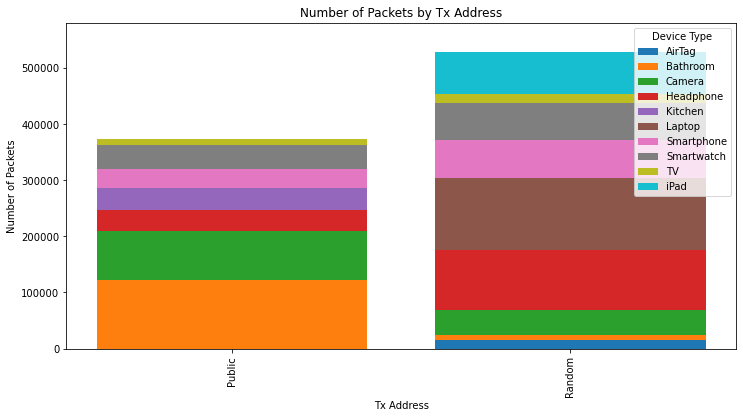

In [33]:
save_path = "Diagrams/Number of Packets by Tx Address.png"
plot_direct_features(input_csv_file, 0, 'Tx Address', 'Tx Address', save_path)

Rx Address
Public      7
Random    111
Name: AirTag, dtype: int64
Rx Address
Public    7903
Random       1
Name: Bathroom, dtype: int64
Rx Address
Public    6631
Random    3810
Name: Camera, dtype: int64
Rx Address
Public     232
Random    1354
Name: Headphone, dtype: int64
Rx Address
Public    1235
Name: Kitchen, dtype: int64
Rx Address
Public    2
Random    6
Name: Laptop, dtype: int64
Rx Address
Public    6460
Random    1216
Name: Smartphone, dtype: int64
Rx Address
Public     2190
Random    10349
Name: Smartwatch, dtype: int64
Rx Address
Public    2764
Random    3010
Name: TV, dtype: int64
Rx Address
Public     24
Random    342
Name: iPad, dtype: int64


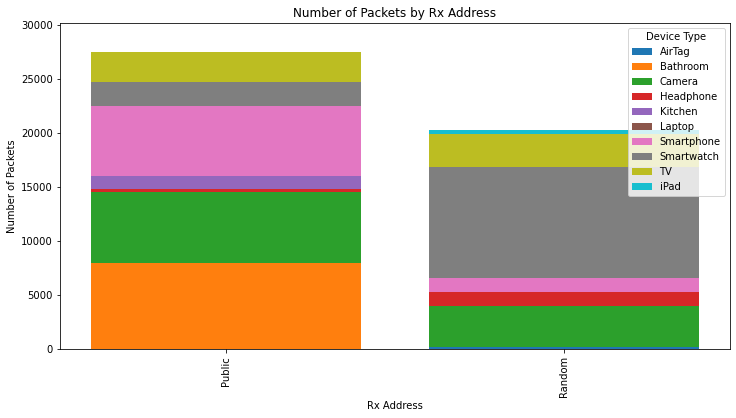

In [34]:
save_path = "Diagrams/Number of Packets by Rx Address.png"
plot_direct_features(input_csv_file, 0, 'Rx Address', 'Rx Address', save_path)

Length.1
6.0       82
12.0     112
20.0       2
21.0       3
23.0    3787
24.0    1965
25.0    2368
26.0       2
27.0       3
28.0       1
29.0       2
33.0     123
37.0    7084
Name: AirTag, dtype: int64
Length.1
12.0      7888
20.0         3
21.0         8
23.0       680
24.0    114967
25.0         1
36.0         5
37.0         1
Name: Bathroom, dtype: int64
Length.1
10.0        2
12.0    10374
20.0        3
21.0        2
23.0     3633
28.0        3
29.0    41161
33.0    39852
37.0    33039
Name: Camera, dtype: int64
Length.1
6.0       357
12.0     1583
20.0     4399
21.0    16491
23.0       23
24.0       51
25.0        7
26.0    30267
27.0    19797
28.0     6127
29.0    17583
32.0     5918
33.0    11611
36.0       37
37.0    30249
Name: Headphone, dtype: int64
Length.1
12.0     1224
21.0      481
24.0      307
25.0    31618
27.0        1
32.0     1916
36.0      344
Name: Kitchen, dtype: int64
Length.1
6.0          6
12.0         6
20.0       577
21.0         1
23.0      1792
24.0   

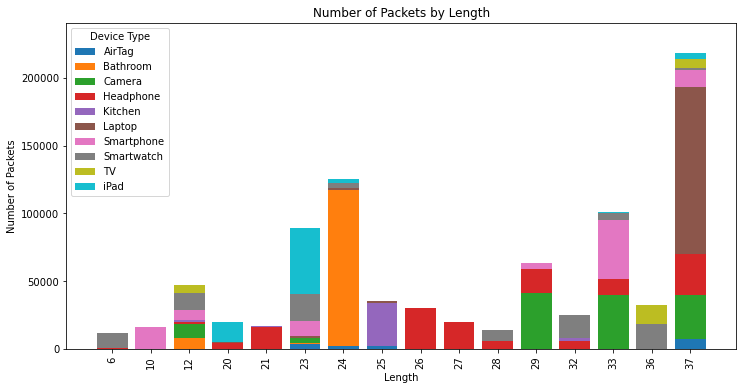

In [35]:
save_path = "Diagrams/Number of Packets by Length.1.png"
plot_direct_features(input_csv_file, 10000, 'Length.1', 'Length', save_path)

Simultaneous LE and BR/EDR to Same Device Capable (Host)
false       6
true     6812
Name: AirTag, dtype: int64
Simultaneous LE and BR/EDR to Same Device Capable (Host)
false    6188
true       18
Name: Bathroom, dtype: int64
Simultaneous LE and BR/EDR to Same Device Capable (Host)
false    4944
Name: Camera, dtype: int64
Simultaneous LE and BR/EDR to Same Device Capable (Host)
false    1149
true     4408
Name: Headphone, dtype: int64
Simultaneous LE and BR/EDR to Same Device Capable (Host)
false    9939
true        1
Name: Kitchen, dtype: int64
Simultaneous LE and BR/EDR to Same Device Capable (Host)
false     453
true     6347
Name: Smartphone, dtype: int64
Simultaneous LE and BR/EDR to Same Device Capable (Host)
false    7562
true      320
Name: Smartwatch, dtype: int64
Simultaneous LE and BR/EDR to Same Device Capable (Host)
false       28
true     14756
Name: TV, dtype: int64
Simultaneous LE and BR/EDR to Same Device Capable (Host)
true    10215
Name: iPad, dtype: int64


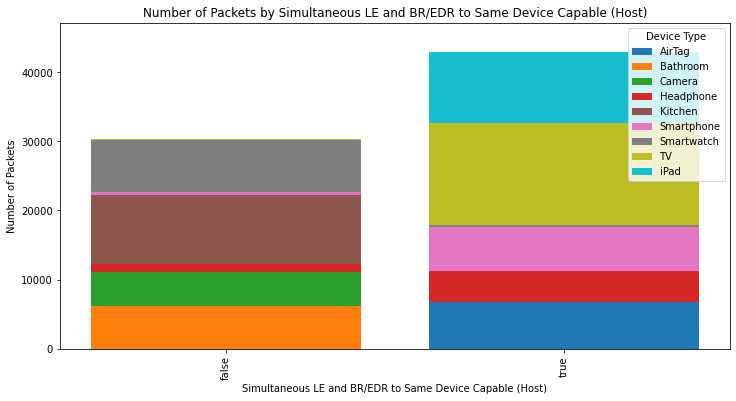

In [36]:
save_path = "Diagrams/Number of Packets by Simultaneous LE and BR EDR to Same Device Capable (Host).png"
plot_direct_features(input_csv_file, 100, 'Simultaneous LE and BR/EDR to Same Device Capable (Host)', 'Simultaneous LE and BR/EDR to Same Device Capable (Host)', save_path, 'lower')

Simultaneous LE and BR/EDR to Same Device Capable (Controller)
false       8
true     6810
Name: AirTag, dtype: int64
Simultaneous LE and BR/EDR to Same Device Capable (Controller)
false    6186
true       20
Name: Bathroom, dtype: int64
Simultaneous LE and BR/EDR to Same Device Capable (Controller)
false    4944
Name: Camera, dtype: int64
Simultaneous LE and BR/EDR to Same Device Capable (Controller)
false    1150
true     4407
Name: Headphone, dtype: int64
Simultaneous LE and BR/EDR to Same Device Capable (Controller)
false    9940
Name: Kitchen, dtype: int64
Simultaneous LE and BR/EDR to Same Device Capable (Controller)
false     453
true     6347
Name: Smartphone, dtype: int64
Simultaneous LE and BR/EDR to Same Device Capable (Controller)
false    7562
true      320
Name: Smartwatch, dtype: int64
Simultaneous LE and BR/EDR to Same Device Capable (Controller)
false       47
true     14737
Name: TV, dtype: int64
Simultaneous LE and BR/EDR to Same Device Capable (Controller)
false    

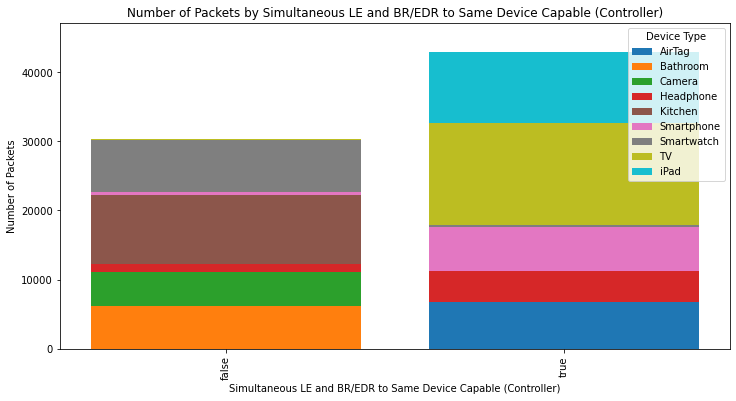

In [37]:
save_path = "Diagrams/Number of Packets by Simultaneous LE and BR EDR to Same Device Capable (Controller).png"
plot_direct_features(input_csv_file, 100, 'Simultaneous LE and BR/EDR to Same Device Capable (Controller)', 'Simultaneous LE and BR/EDR to Same Device Capable (Controller)', save_path, 'lower')

BR/EDR Not Supported
false    6799
true       19
Name: AirTag, dtype: int64
BR/EDR Not Supported
false      21
true     6185
Name: Bathroom, dtype: int64
BR/EDR Not Supported
false    4487
true      457
Name: Camera, dtype: int64
BR/EDR Not Supported
false    5554
true        3
Name: Headphone, dtype: int64
BR/EDR Not Supported
false       1
true     9939
Name: Kitchen, dtype: int64
BR/EDR Not Supported
false    6793
true        7
Name: Smartphone, dtype: int64
BR/EDR Not Supported
false     320
true     7562
Name: Smartwatch, dtype: int64
BR/EDR Not Supported
false    14703
true        81
Name: TV, dtype: int64
BR/EDR Not Supported
false    10214
true         1
Name: iPad, dtype: int64


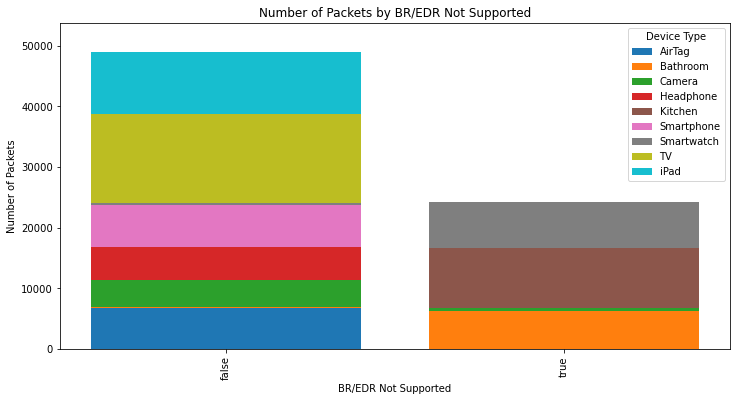

In [38]:
save_path = "Diagrams/Number of Packets by BR EDR Not Supported.png"
plot_direct_features(input_csv_file, 100, 'BR/EDR Not Supported', 'BR/EDR Not Supported', save_path, 'lower')

LE General Discoverable Mode
false      12
true     6806
Name: AirTag, dtype: int64
LE General Discoverable Mode
false    6195
true       11
Name: Bathroom, dtype: int64
LE General Discoverable Mode
false     457
true     4487
Name: Camera, dtype: int64
LE General Discoverable Mode
false    4395
true     1162
Name: Headphone, dtype: int64
LE General Discoverable Mode
false       4
true     9936
Name: Kitchen, dtype: int64
LE General Discoverable Mode
true    6800
Name: Smartphone, dtype: int64
LE General Discoverable Mode
false    1567
true     6315
Name: Smartwatch, dtype: int64
LE General Discoverable Mode
false       66
true     14718
Name: TV, dtype: int64
LE General Discoverable Mode
false        1
true     10214
Name: iPad, dtype: int64


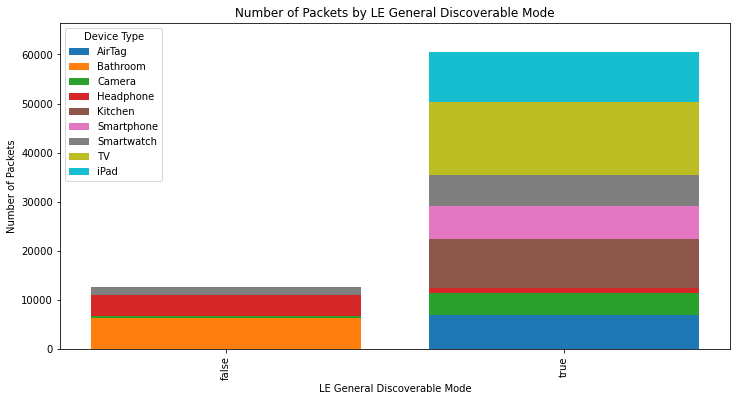

In [39]:
save_path = "Diagrams/Number of Packets by LE General Discoverable Mode.png"
plot_direct_features(input_csv_file, 100, 'LE General Discoverable Mode', 'LE General Discoverable Mode', save_path, 'lower')

LE Limited Discoverable Mode
false    6812
true        6
Name: AirTag, dtype: int64
LE Limited Discoverable Mode
false       3
true     6203
Name: Bathroom, dtype: int64
LE Limited Discoverable Mode
false    4487
true      457
Name: Camera, dtype: int64
LE Limited Discoverable Mode
false    5556
true        1
Name: Headphone, dtype: int64
LE Limited Discoverable Mode
false    9939
true        1
Name: Kitchen, dtype: int64
LE Limited Discoverable Mode
false    6798
true        2
Name: Smartphone, dtype: int64
LE Limited Discoverable Mode
false    7882
Name: Smartwatch, dtype: int64
LE Limited Discoverable Mode
false    14749
true        35
Name: TV, dtype: int64
LE Limited Discoverable Mode
false    10215
Name: iPad, dtype: int64


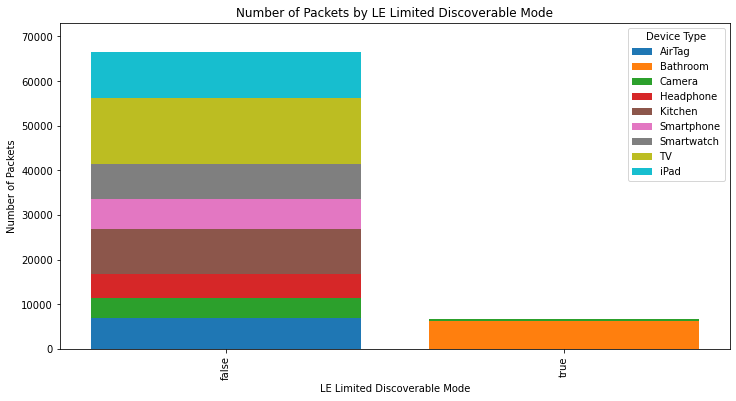

In [40]:
save_path = "Diagrams/Number of Packets by LE Limited Discoverable Mode.png"
plot_direct_features(input_csv_file, 100, 'LE Limited Discoverable Mode', 'LE Limited Discoverable Mode', save_path, 'lower')

Power Level (dBm)
0.0        3
6.0     1320
7.0      757
8.0      817
9.0      470
12.0    3335
17.0     315
Name: AirTag, dtype: int64
Power Level (dBm)
0.0    7174
Name: Bathroom, dtype: int64
Power Level (dBm)
6.0     3633
12.0       1
Name: Camera, dtype: int64
Power Level (dBm)
-44.0        3
-21.0    33811
-7.0      5809
 7.0        13
 8.0         5
 12.0       51
Name: Headphone, dtype: int64
Power Level (dBm)
9.0      350
12.0    2379
17.0     400
Name: Laptop, dtype: int64
Power Level (dBm)
0.0        2
7.0     7101
8.0       30
9.0        1
12.0      70
Name: Smartphone, dtype: int64
Power Level (dBm)
0.0        19
7.0        14
8.0      7026
9.0      3098
12.0    13686
Name: Smartwatch, dtype: int64
Power Level (dBm)
-44.0    14578
Name: TV, dtype: int64
Power Level (dBm)
0.0         2
6.0        82
8.0      6590
9.0         3
12.0    29516
17.0    14701
Name: iPad, dtype: int64


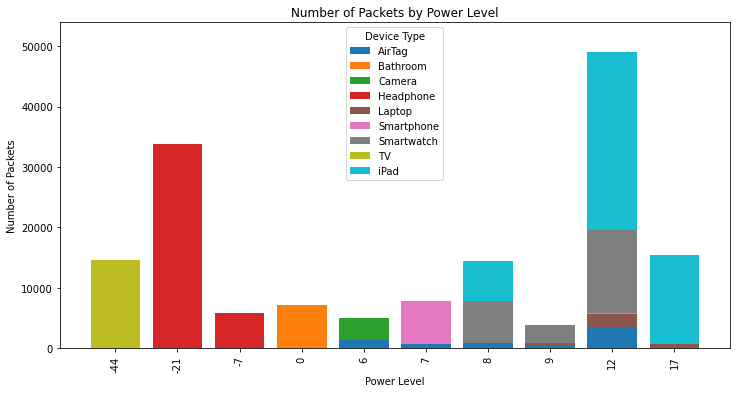

In [41]:
save_path = "Diagrams/Number of Packets by Power Level (dBm).png"
plot_direct_features(input_csv_file, 1000, 'Power Level (dBm)', 'Power Level', save_path, power_level='yes')

# DERIVED FEATURES

In [42]:
# function which plots for each feature a bar chart: y axis is the number of packets and x axis is the feature
def plot_derived_features(input_csv_file, filtering_size, feature, name, save_path=None, lowercase=None, toothbrush=None, rounding=None):
    df = pd.read_csv(input_csv_file, delimiter=';', error_bad_lines=False, encoding='ISO-8859-1')

    if lowercase:
        df[feature] = df[feature].str.lower()
    filtered_df = df[df.groupby(feature)[feature].transform('size') >= filtering_size]
    grouped_df = filtered_df.groupby([feature, 'label']).size().unstack(fill_value=0)
    
    if rounding:
        if rounding == '0':
            grouped_df.index = np.round(grouped_df.index.values).astype(int)
            grouped_df = grouped_df.groupby(grouped_df.index).sum()
        elif rounding == 'milisecond':
            grouped_df.index = np.round(grouped_df.index.values * 1000).astype(int)
            grouped_df = grouped_df.groupby(grouped_df.index).sum()
        else:
            grouped_df.index = np.round(grouped_df.index.values, 3)

    labels = grouped_df.columns
    colors = plt.cm.get_cmap('tab10', len(labels))

    x_values = grouped_df.index.tolist()
    bar_width = 0.35

    plt.figure(figsize=(12, 6))
    bars = None
    bottom = np.zeros(len(x_values)) 
    for i, label in enumerate(labels):
        label_data = grouped_df[label]
        non_zero_values = label_data[label_data > 0]
        if not non_zero_values.empty:
            print(non_zero_values)

    if toothbrush:
        filtered_df = filtered_df[filtered_df['subcategory'] != 'Toothbrush']
        grouped_df = filtered_df.groupby([feature, 'label']).size().unstack(fill_value=0)
        if rounding:
            if rounding == '0':
                grouped_df.index = np.round(grouped_df.index.values).astype(int)
                grouped_df = grouped_df.groupby(grouped_df.index).sum()
            elif rounding == 'milisecond':
                grouped_df.index = np.round(grouped_df.index.values * 1000).astype(int)
                grouped_df = grouped_df.groupby(grouped_df.index).sum()
            else:
                grouped_df.index = np.round(grouped_df.index.values, 3)
        x_values = grouped_df.index.tolist()
        bottom = np.zeros(len(x_values))

    for i, label in enumerate(labels):
        label_data = grouped_df[label]
        bars = plt.bar(np.arange(len(x_values)), label_data, color=colors(i), label=label, bottom=bottom)
        bottom += label_data

    plt.title(f"Number of Packets by {name}")
    plt.xlabel(name)
    plt.ylabel('Number of Packets')

    if len(x_values) > 40:
        tick_spacing = (len(x_values) // 40) + 1
    else:
        tick_spacing = 1

    def format_xtick(x):
        return f'{int(x)}' if isinstance(x, (int, float)) and float(x).is_integer() else f'{x:.3f}' if isinstance(x, (int, float)) else str(x)

    formatted_x_values = [format_xtick(x) for x in x_values]

    if rounding:
        if rounding == '0':
            plt.xticks(np.arange(0, len(x_values), tick_spacing), [format_xtick(x) for x in x_values[::tick_spacing]], rotation=90)
        elif rounding == 'milisecond':
            plt.xticks(np.arange(0, len(x_values), tick_spacing), [format_xtick(x) for x in x_values[::tick_spacing]], rotation=90)
        else:
            plt.xticks(np.arange(0, len(x_values), tick_spacing), [format_xtick(x) for x in x_values[::tick_spacing]], rotation=90)
    else:
        plt.xticks(np.arange(0, len(x_values), tick_spacing), [format_xtick(x) for x in x_values[::tick_spacing]], rotation=90)

    plt.legend(title='Device Type')

    y_max = bottom.max()
    plt.ylim(0, y_max * 1.1)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

461     1306
1633    2220
1634    4539
Name: AirTag, dtype: int64
1202      1044
1203    129757
Name: Bathroom, dtype: int64
1201    44375
1203    14196
1208    41003
1229     7019
1267     1474
1268     6295
1346    16152
Name: Camera, dtype: int64
74       3331
91       1895
255      1876
350      2676
421      4065
422      5916
551     19771
695     11085
865     39780
1224    48422
1442     5130
Name: Headphone, dtype: int64
1157    29744
1196     1961
1199     2844
1201     3678
Name: Kitchen, dtype: int64
101     2860
148     4133
205     5773
206     5716
228     6448
288     8826
409    12300
433    12188
453    12786
548    15689
600    33501
710     1043
729     1093
Name: Laptop, dtype: int64
10       2477
78       1404
119      1073
130      1224
151      1334
185      1639
286      2915
337      1088
367      8504
437      4314
484      5107
581      1658
913      5017
921      1302
1206     1666
1219    36080
Name: Smartphone, dtype: int64
156      4914
1106     9071
121

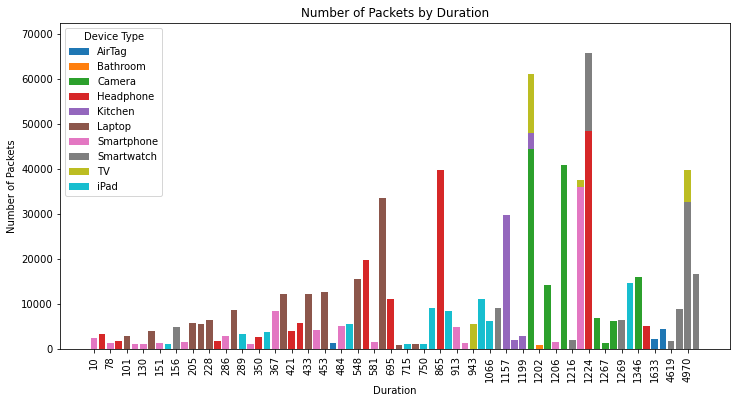

In [43]:
save_path = "Diagrams1/Number of Packets by Duration 1.png"
plot_derived_features(input_csv_file, 1000, 'Duration 1', 'Duration', save_path, toothbrush='yes', rounding='0')

1    6759
3    1306
Name: AirTag, dtype: int64
1        1044
108    129757
Name: Bathroom, dtype: int64
1      1474
5      6295
6      7019
12    30348
34    41003
37    44375
Name: Camera, dtype: int64
1      1811
2      3319
7      1876
8      2676
10     4065
12    15088
14     5916
16    11085
17     9601
18    10170
21     1895
27    33334
45     3331
46    39780
Name: Headphone, dtype: int64
1      1750
2      6733
26    29744
Name: Kitchen, dtype: int64
1      2136
28    83405
29    15689
30    12300
31     8826
Name: Laptop, dtype: int64
1      2968
3      2746
5      5017
9      5270
10    11080
11     5107
13     4653
18     1404
30    36080
Name: Smartphone, dtype: int64
0      1842
1      4899
2     39700
3     15791
5      6567
8      9071
14    17371
31     4914
Name: Smartwatch, dtype: int64
1      8676
6      5513
11    12968
Name: TV, dtype: int64
2      2275
6      6234
8      1241
10     8470
11    38921
12     8989
Name: iPad, dtype: int64


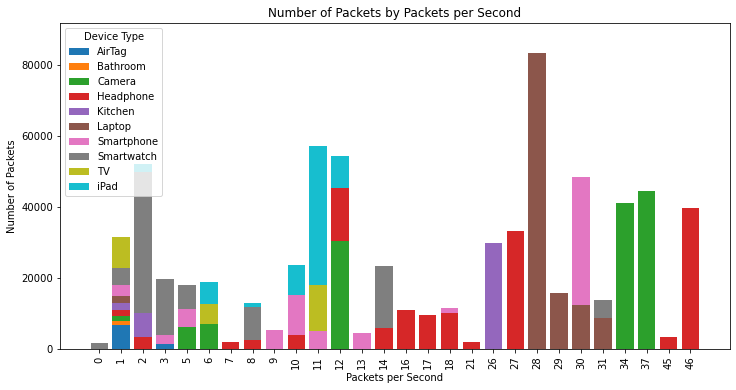

In [44]:
save_path = "Diagrams1/Number of Packets by Packets per Second 1.png"
plot_derived_features(input_csv_file, 1000, 'Packets per Second 1', 'Packets per Second', save_path, toothbrush='yes', rounding='0')

353    1306
704    2320
736    4439
Name: AirTag, dtype: int64
9       129757
1151      1044
Name: Bathroom, dtype: int64
27     44375
29     41003
83     16152
85     14196
175     7019
201     6295
859     1474
Name: Camera, dtype: int64
22     43111
37     33334
48      1895
54     10170
57      9601
63     11085
71      5916
81     15088
104     4065
131     2676
136     1876
434     3319
796     1811
Name: Headphone, dtype: int64
39     29744
422     2844
610     1961
623     1928
686     1750
Name: Kitchen, dtype: int64
33     21126
35     66878
36     32216
667     1093
681     1043
Name: Laptop, dtype: int64
34     36080
56      1404
79      4653
95      8958
98      2915
101     4314
106     1224
111     1073
113     2973
182     5017
309     1088
351     1658
707     1302
724     1666
Name: Smartphone, dtype: int64
32       4914
70      17371
122      9071
193      6567
315     15791
423     11744
533      9030
553      8992
588      2070
632      7864
1015     4899
2507     

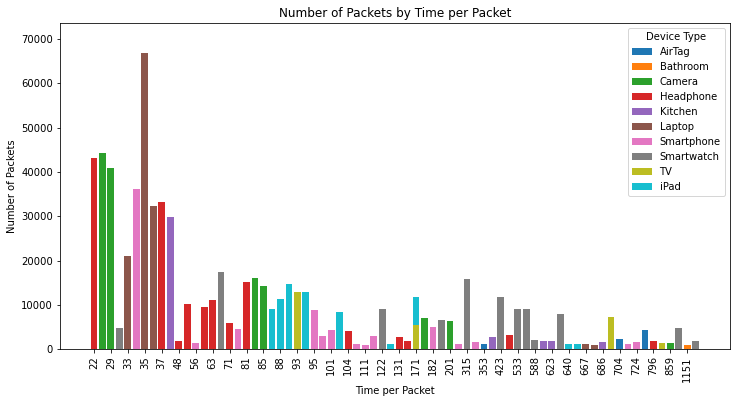

In [45]:
save_path = "Diagrams1/Number of Packets by Time per Packet 1.png"
plot_derived_features(input_csv_file, 1000, 'Time per Packet 1', 'Time per Packet', save_path, toothbrush='yes', rounding='milisecond')

50    4439
52    2320
71    1306
Name: AirTag, dtype: int64
20        1044
2573    129757
Name: Bathroom, dtype: int64
34       1474
144      6295
166      7019
317     14196
323     16152
1125    41003
1159    44375
Name: Camera, dtype: int64
46       1811
65       3319
146      1876
152      2676
345      4065
401     15088
471      9601
499     10170
508      5916
576     11085
700     33334
758      1895
1229     3331
1251    39780
Name: Headphone, dtype: int64
36      1961
38      1750
53      1928
66      2844
639    29744
Name: Kitchen, dtype: int64
54       1043
55       1093
1023    16594
1029     5716
1036     4133
1040     5773
1042    16907
1043    12188
1044    12786
1045     6448
1047     2860
1059    15689
1111    12300
1132     8826
Name: Laptop, dtype: int64
29      1658
32      1666
33      1302
34      1088
108     3851
110     5107
118     5017
140     4653
221     2915
325     1639
327     1334
332     1073
337     4314
349     1224
658     1404
852    36080
Name: 

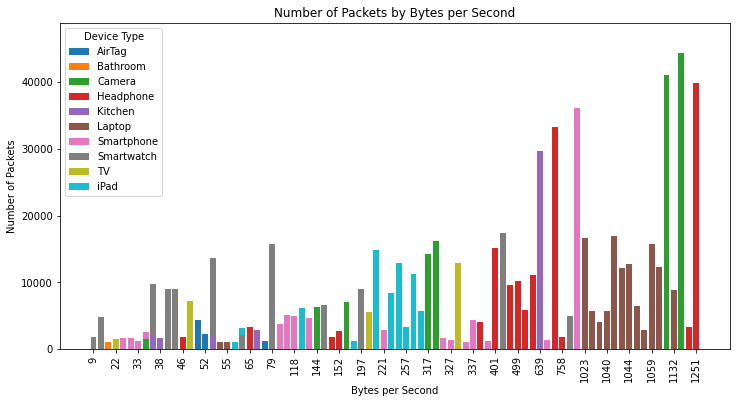

In [46]:
save_path = "Diagrams1/Number of Packets by Bytes per Second 1.png"
plot_derived_features(input_csv_file, 1000, 'Bytes per Second 1', 'Bytes per Second', save_path, toothbrush='yes', rounding='0')

Min RSSI 1
-95       3
-94    1669
-93    4055
-92    1389
-91    1454
-90     628
-89     203
-88      52
-87      47
-86    2232
-85       4
-84    2320
-82       3
-81    2220
-80       2
Name: AirTag, dtype: int64
Min RSSI 1
-95      1044
-89    129757
Name: Bathroom, dtype: int64
Min RSSI 1
-96    41004
-94    16152
-93    58571
-92        1
-89        5
-88        6
-69       69
-64     6295
-62     7019
-55        1
-47        1
-45        2
-44        1
-37     1474
Name: Camera, dtype: int64
Min RSSI 1
-94        3
-93        2
-92       33
-91     4553
-90    33411
-89       17
-88       19
-87        6
-86     3324
-85     9605
-83        1
-81        5
-80    39780
-78     7727
-77    11085
-76     1895
-74    10170
-66    19153
-64     3331
-61        1
-55      421
-50        2
-47        1
-45        2
-44        3
-41        3
-40        2
-39        8
-37        1
-32        2
Name: Headphone, dtype: int64
Min RSSI 1
-92     1928
-91     2844
-89    31494
-84     1961


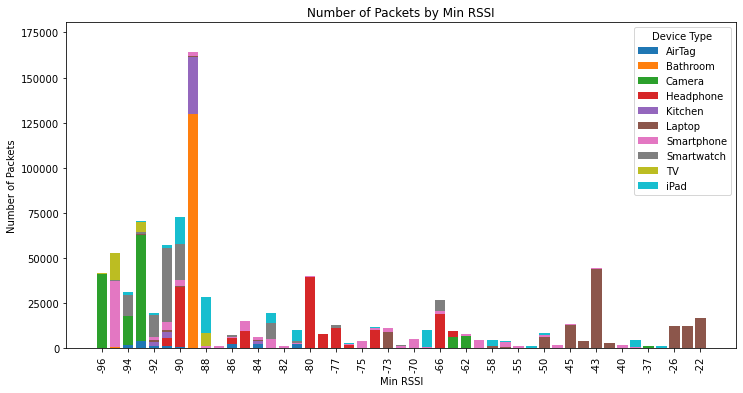

In [47]:
save_path = "Diagrams1/Number of Packets by Min RSSI 1.png"
plot_derived_features(input_csv_file, 1000, 'Min RSSI 1', 'Min RSSI', save_path)

Max RSSI 1
-71      33
-63     195
-62     244
-61     118
-60    1120
-58     573
-57    1360
-56    1195
-54     400
-53    1306
-46     563
-33    2320
-31    2220
-28    2219
Name: AirTag, dtype: int64
Max RSSI 1
-47      1044
-46         3
-35         1
-29    129757
Name: Bathroom, dtype: int64
Max RSSI 1
-63        1
-49        2
-47        1
-45        2
-44        1
-38        1
-37     7019
-35     6295
-34    14196
-33    41003
-31    45849
-25    16152
Name: Camera, dtype: int64
Max RSSI 1
-71     1876
-61     2677
-56        1
-51        3
-50        2
-49        3
-47        1
-46        4
-45        2
-44        3
-40        2
-39     3331
-38    39784
-37        3
-36     1823
-31    48423
-30        5
-29       10
-28        2
-26    10205
-25        1
-24     9601
-23     3319
-22      110
-17    22961
Name: Headphone, dtype: int64
Max RSSI 1
-71        1
-62        1
-57        1
-53        1
-47        1
-44     1961
-40     2844
-35     1750
-34     1928
-20    297

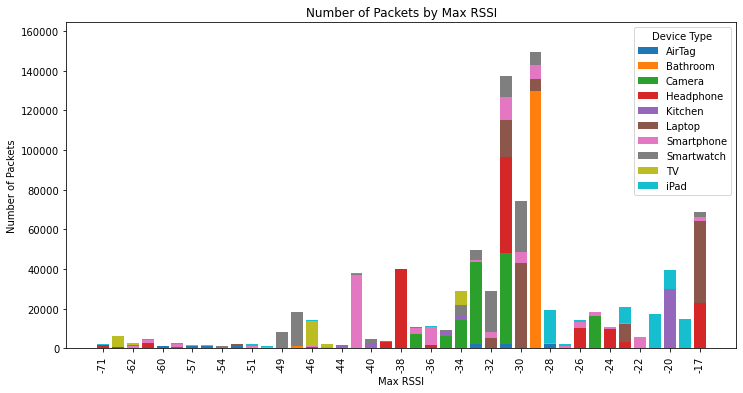

In [48]:
save_path = "Diagrams1/Number of Packets by Max RSSI 1.png"
plot_derived_features(input_csv_file, 1000, 'Max RSSI 1', 'Max RSSI', save_path)

Sum RSSI 1
-101218    1306
-95557     2320
-85117     2219
-79985     2220
Name: AirTag, dtype: int64
Sum RSSI 1
-5781100    129757
-90052        1044
Name: Bathroom, dtype: int64
Sum RSSI 1
-2625041    44375
-1937892    41003
-749949     14196
-484417     16152
-311556      7019
-285491      6295
-47665       1474
Name: Camera, dtype: int64
Sum RSSI 1
-1738071    39780
-1516051    33334
-741894     15088
-411155     10170
-364478      9601
-351971     11085
-201998      5916
-201700      2676
-161007      4065
-154410      3331
-143471      1876
-102054      3319
-80413       1811
-75503       1895
Name: Headphone, dtype: int64
Sum RSSI 1
-1768956    29744
-161270      2844
-106156      1961
-88192       1928
-85053       1750
Name: Kitchen, dtype: int64
Sum RSSI 1
-610647    16907
-602700    15689
-482856    12786
-315106    16594
-302892     8826
-239026     6448
-232670    12300
-231560    12188
-215803     5773
-214566     5716
-145325     4133
-104682     2860
-37071      1093
-3

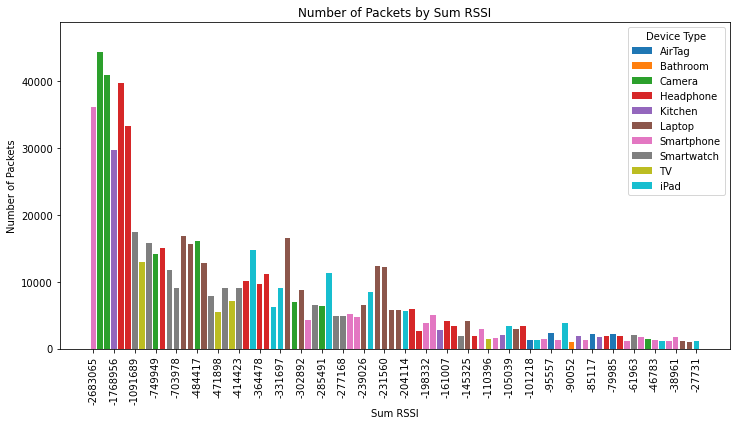

In [49]:
save_path = "Diagrams1/Number of Packets by Sum RSSI 1.png"
plot_derived_features(input_csv_file, 1000, 'Sum RSSI 1', 'Sum RSSI', save_path, toothbrush='yes')

-78    1306
-41    2320
-38    2219
-36    2220
Name: AirTag, dtype: int64
-86      1044
-45    129757
Name: Bathroom, dtype: int64
-59    44375
-53    14196
-52    16152
-47    41003
-45     6295
-44     7019
-32     1474
Name: Camera, dtype: int64
-76     1876
-75     2676
-49    15088
-46     3331
-45    33334
-44    41591
-40    16130
-38     9601
-34     5916
-32    11085
-31     3319
Name: Headphone, dtype: int64
-59    29744
-57     2844
-54     1961
-49     1750
-46     1928
Name: Kitchen, dtype: int64
-38    34191
-37    15081
-36    16907
-35     4133
-34    10962
-19    41082
Name: Laptop, dtype: int64
-74    36080
-72     1224
-71     1334
-70     1404
-69     1073
-68     4314
-67     1639
-52     8504
-51     5107
-39     2915
-38     5017
-37     1658
-36     2390
-23     1666
Name: Smartphone, dtype: int64
-82     1842
-78     8992
-63    17371
-61    19608
-57    25604
-48     9030
-46     9071
-44     6567
-30     2070
Name: Smartwatch, dtype: int64
-86     5513
-79  

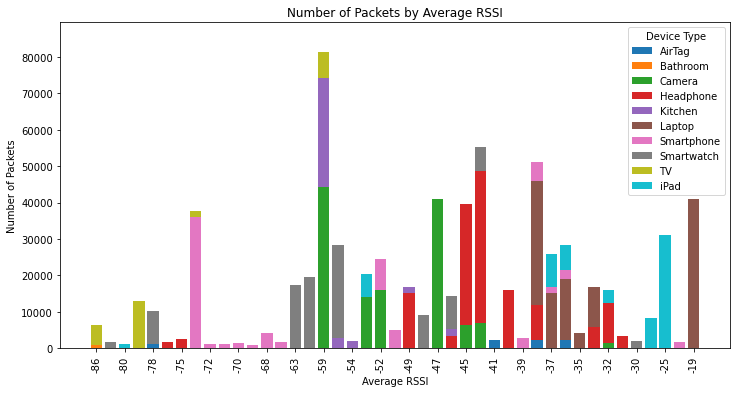

In [50]:
save_path = "Diagrams1/Number of Packets by Average RSSI 1.png"
plot_derived_features(input_csv_file, 1000, 'Average RSSI 1', 'Average RSSI', save_path, toothbrush='yes', rounding='0')

3    2220
4    2320
6    2219
8    1306
Name: AirTag, dtype: int64
6    129757
7      1044
Name: Bathroom, dtype: int64
1      1474
3     13314
7     44375
13    14196
14    41003
19    16152
Name: Camera, dtype: int64
2     5142
3    33334
4    59420
5    10170
6    13666
7    22215
Name: Headphone, dtype: int64
5     3711
6    31672
7     2844
Name: Kitchen, dtype: int64
1    18549
2    90848
4     4133
6     8826
Name: Laptop, dtype: int64
2     1658
3     3851
4    11327
5     5741
6    46132
7     1302
8     4314
Name: Smartphone, dtype: int64
4     14431
5     11744
6     26442
8      2070
9     17633
10    27835
Name: Smartwatch, dtype: int64
2      5513
5      7189
10     1487
13    12968
Name: TV, dtype: int64
2     8470
4    15913
5    24618
7     1241
8     5659
9    10229
Name: iPad, dtype: int64


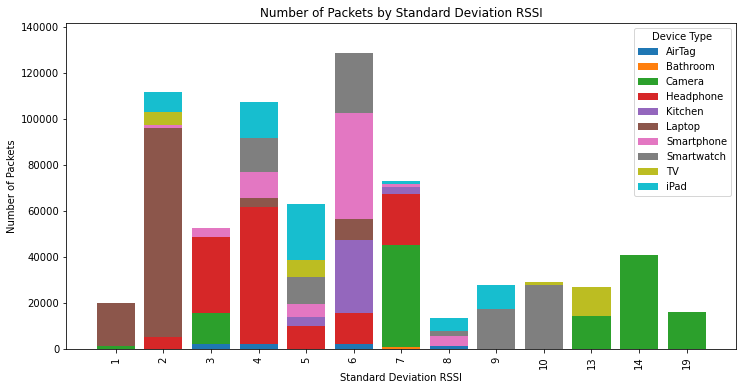

In [51]:
save_path = "Diagrams1/Number of Packets by Standard Deviation RSSI 1.png"
plot_derived_features(input_csv_file, 1000, 'Standard Deviation RSSI 1', 'Standard Deviation RSSI', save_path, toothbrush='yes', rounding='0')

10    2220
19    2320
40    2219
61    1306
Name: AirTag, dtype: int64
34    129757
46      1044
Name: Bathroom, dtype: int64
0       1474
10      6295
11      7019
44     44375
174    14196
187    41003
360    16152
Name: Camera, dtype: int64
3      3331
5      1811
12    33334
16    39780
18    15088
19     2676
20     1876
30    10170
31     4065
39     9601
44     3319
45     1895
50     5916
51    11085
Name: Headphone, dtype: int64
21     1750
25     1961
36     1928
38    29744
47     2844
Name: Kitchen, dtype: int64
1      2860
2     32596
3     46855
4     19595
5      1043
6      6448
17     4133
34     8826
Name: Laptop, dtype: int64
5      1658
12     8958
14     1639
16     2915
18     1666
20     4653
21     1088
31     1224
34     1404
36     1073
37     6351
41    36080
55     1302
69     4314
Name: Smartphone, dtype: int64
17      7864
19      6567
28     11744
34     17371
35      9071
62      2070
73      1842
87     15791
92      9030
95      4899
102     4914
107  

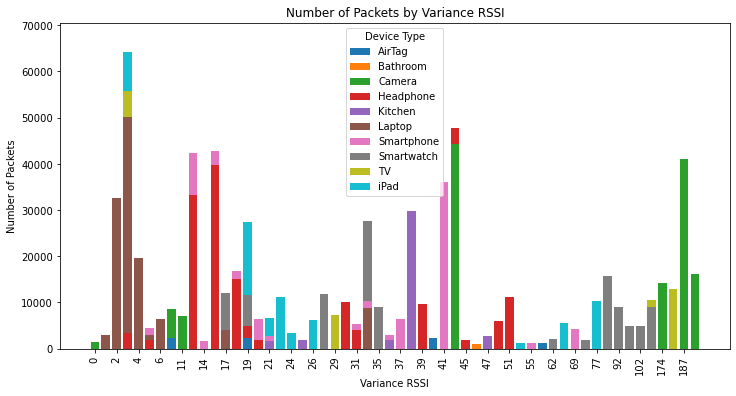

In [52]:
save_path = "Diagrams1/Number of Packets by Variance RSSI 1.png"
plot_derived_features(input_csv_file, 1000, 'Variance RSSI 1', 'Variance RSSI', save_path, toothbrush='yes', rounding='0')

Min Packet Length 1
6     11223
9      1306
12      545
14      599
16      355
23     1607
24       53
25       53
26        2
31        1
33      124
37      365
Name: AirTag, dtype: int64
Min Packet Length 1
7       1044
12    129760
Name: Bathroom, dtype: int64
Min Packet Length 1
10    57155
12    58581
29    14867
33        4
Name: Camera, dtype: int64
Min Packet Length 1
6     88233
11        1
12    33219
14       17
19    10170
23       10
24       10
25        7
26     3332
27     9631
31        1
37       48
Name: Headphone, dtype: int64
Min Packet Length 1
12    38227
25       11
27        1
Name: Kitchen, dtype: int64
Min Packet Length 1
6        673
9        280
12         3
14       448
16       645
19       332
23      1098
24       419
25       859
33         1
37    122570
Name: Laptop, dtype: int64
Min Packet Length 1
6     12700
10    17235
11     8430
12    36096
14     1043
19        6
23     3391
24       24
25       65
31     4316
33    14749
37     3994
Name: S

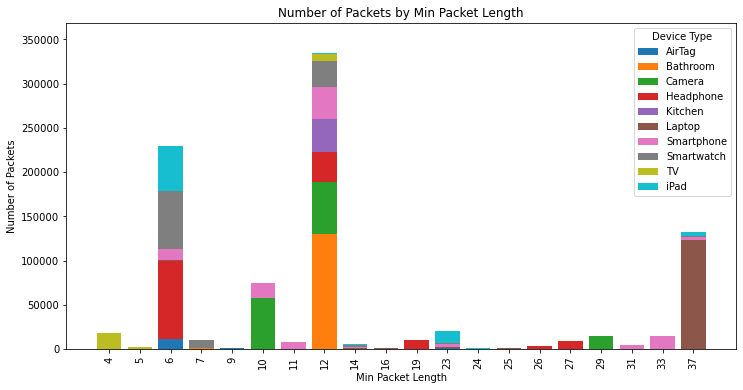

In [53]:
save_path = "Diagrams1/Number of Packets by Min Packet Length 1.png"
plot_derived_features(input_csv_file, 1000, 'Min Packet Length 1', 'Min Packet Length', save_path)

Max Packet Length 1
14      595
20        1
23     2868
24      233
27       33
31        1
33        2
37     7124
40       31
46       13
89      870
97     1428
151       2
Name: AirTag, dtype: int64
Max Packet Length 1
34          4
104    129757
215      1044
Name: Bathroom, dtype: int64
Max Packet Length 1
29     14877
33         4
97     44375
108    16152
140    14196
204    41003
Name: Camera, dtype: int64
Max Packet Length 1
14        17
20      2677
23        10
24        51
27     10198
28      1876
29      3331
31         1
33     33334
34      3319
36        38
37     18909
43      9601
45     11085
101     4065
154    39780
164        1
165     5918
Name: Headphone, dtype: int64
Max Packet Length 1
27        1
34    29744
35     4772
36     3711
Name: Kitchen, dtype: int64
Max Packet Length 1
14        302
20        328
23       1070
24        545
28        642
33          1
34        100
36        254
37     122566
151       250
165         2
215         1
Name: Laptop,

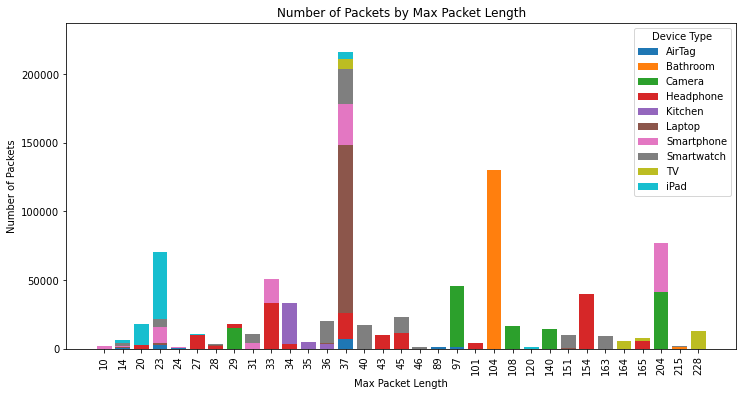

In [54]:
save_path = "Diagrams1/Number of Packets by Max Packet Length 1.png"
plot_derived_features(input_csv_file, 1000, 'Max Packet Length 1', 'Max Packet Length', save_path)

Sum Packet Length 1
32765    1306
81630    2219
81748    2220
85591    2320
Name: AirTag, dtype: int64
Sum Packet Length 1
23633        1044
3094907    129757
Name: Bathroom, dtype: int64
Sum Packet Length 1
42746       1474
182555      6295
203551      7019
381357     14196
435000     16152
1359951    41003
1391822    44375
Name: Camera, dtype: int64
Sum Packet Length 1
37281       1876
53055       2676
66974       1811
68640       1895
90620       3331
93245       3319
145322      4065
214079      5916
259243      9601
274574     10170
399928     11085
490946     15088
857551     33334
1082493    39780
Name: Headphone, dtype: int64
Sum Packet Length 1
43536      1961
45862      1750
63085      1928
79654      2844
739362    29744
Name: Kitchen, dtype: int64
Sum Packet Length 1
38591      1043
40441      1093
105820     2860
152921     4133
211492     5716
213601     5773
238576     6448
326562     8826
450956    12188
455100    12300
473082    12786
580493    15689
613978    16594
62

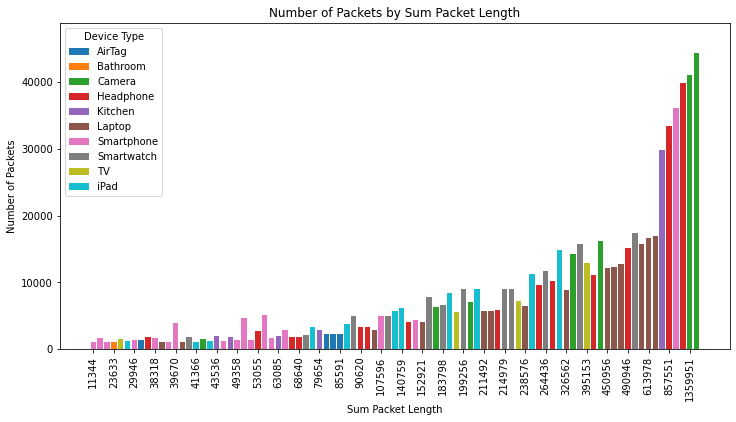

In [55]:
save_path = "Diagrams1/Number of Packets by Sum Packet Length 1.png"
plot_derived_features(input_csv_file, 1000, 'Sum Packet Length 1', 'Sum Packet Length', save_path, toothbrush='yes')

14     487
23    1433
25    1306
31       1
33       2
37    7124
Name: AirTag, dtype: int64
23      1044
24    129757
Name: Bathroom, dtype: int64
27    30348
29    14867
31    44375
33    41007
Name: Camera, dtype: int64
14       17
20     4552
23       10
26    33334
27    62882
28     3319
31        1
33    15088
36    22961
37     1830
Name: Headphone, dtype: int64
22     1961
25    29744
26     1750
28     2844
33     1928
Name: Kitchen, dtype: int64
14       255
23       610
33         1
37    122566
Name: Laptop, dtype: int64
10    11705
11     4653
14     1043
21     5017
22     2915
23     3391
29    36080
31     3866
33    13443
34     4314
37     8110
Name: Smartphone, dtype: int64
14     2301
18     4899
22    10872
23    20514
24    18063
25    20705
28     6567
29        1
32    17371
33       59
34     2070
37     1314
Name: Smartwatch, dtype: int64
18     1487
30    12968
32     7189
36     5513
Name: TV, dtype: int64
14     1726
20    14795
22     3330
23    44722
24 

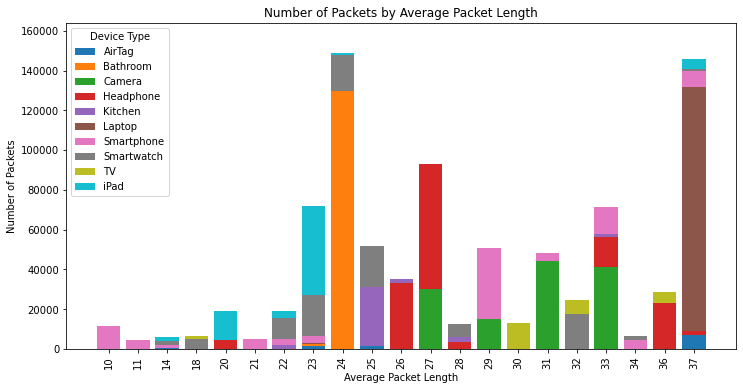

In [56]:
save_path = "Diagrams1/Number of Packets by Average Packet Length 1.png"
plot_derived_features(input_csv_file, 1000, 'Average Packet Length 1', 'Average Packet Length', save_path, rounding='0')

0    2198
2    6759
3    1306
Name: AirTag, dtype: int64
4     129757
19      1044
Name: Bathroom, dtype: int64
0    14857
5    44375
6    30348
8    41003
Name: Camera, dtype: int64
0    19823
1    13013
2    39780
4     1895
5    26173
6    43315
Name: Headphone, dtype: int64
1    29744
4     3678
7     1961
8     2844
Name: Kitchen, dtype: int64
0    124125
Name: Laptop, dtype: int64
0    27449
2     1073
3    13089
4     2915
5     9670
8    40394
Name: Smartphone, dtype: int64
0     28022
1      7864
4      1842
6      2070
7      4899
8      9071
10    11744
12    18022
13    20705
Name: Smartwatch, dtype: int64
3      5513
10     7189
11    12968
12     1487
Name: TV, dtype: int64
0    19682
1    31695
2    14704
3     3330
4     1241
Name: iPad, dtype: int64


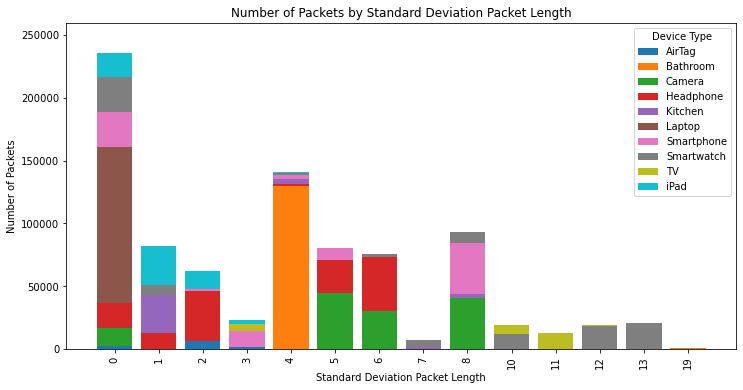

In [57]:
save_path = "Diagrams1/Number of Packets by Standard Deviation Packet Length 1.png"
plot_derived_features(input_csv_file, 1000, 'Standard Deviation Packet Length 1', 'Standard Deviation Packet Length', save_path, rounding='0')

0    2198
3    2320
5    2220
6    2219
7    1306
Name: AirTag, dtype: int64
14     129757
352      1044
Name: Bathroom, dtype: int64
0     14857
26    44375
32    16152
33    14196
71    41003
Name: Camera, dtype: int64
0     21634
1      7871
2      3331
3     39780
19     1895
22    11085
26    15088
31     4065
32     5916
34    33334
Name: Headphone, dtype: int64
2     29744
15     1928
19     1750
44     1961
72     2844
Name: Kitchen, dtype: int64
0    124125
Name: Laptop, dtype: int64
0     27449
2      1073
7      1639
8      3851
9      1404
11     6195
18     2915
20     5017
25     4653
65    36080
66     4314
Name: Smartphone, dtype: int64
0      28022
2       7864
20      1842
35      2070
48      4899
59      9071
104    11744
133     9030
144     8992
166    15791
175     4914
Name: Smartwatch, dtype: int64
7       5513
96      7189
120    12968
134     1487
Name: TV, dtype: int64
0     34477
1     16900
3      8470
6      6234
9      3330
13     1241
Name: iPad, dtype:

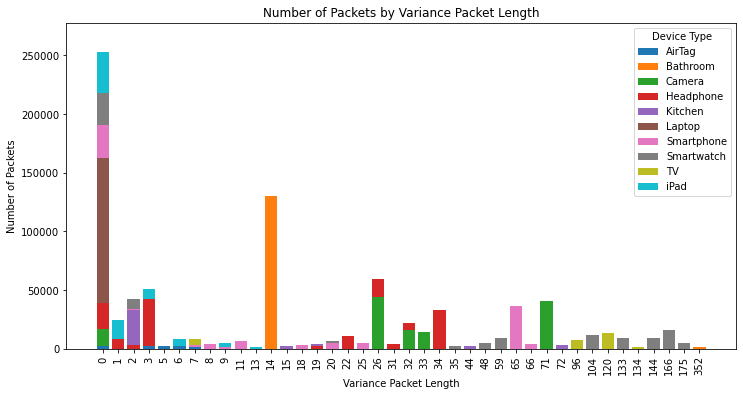

In [58]:
save_path = "Diagrams1/Number of Packets by Variance Packet Length 1.png"
plot_derived_features(input_csv_file, 1000, 'Variance Packet Length 1', 'Variance Packet Length', save_path, rounding='0')

Min Payload Length 1
25    11223
28     1306
31      545
33      599
35      355
42     1607
43       53
44       53
45        2
50        1
52      124
56      365
Name: AirTag, dtype: int64
Min Payload Length 1
26      1044
31    129760
Name: Bathroom, dtype: int64
Min Payload Length 1
29    57155
31    58581
48    14867
52        4
Name: Camera, dtype: int64
Min Payload Length 1
25    88233
30        1
31    33219
33       17
38    10170
42       10
43       10
44        7
45     3332
46     9631
50        1
56       48
Name: Headphone, dtype: int64
Min Payload Length 1
31    38227
44       11
46        1
Name: Kitchen, dtype: int64
Min Payload Length 1
25       673
28       280
31         3
33       448
35       645
38       332
42      1098
43       419
44       859
52         1
56    122570
Name: Laptop, dtype: int64
Min Payload Length 1
25    12700
29    17235
30     8430
31    36096
33     1043
38        6
42     3391
43       24
44       65
50     4316
52    14749
56     3994


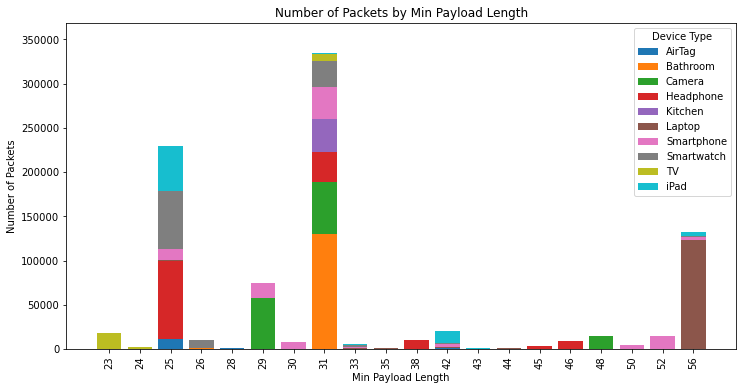

In [59]:
save_path = "Diagrams1/Number of Packets by Min Payload Length 1.png"
plot_derived_features(input_csv_file, 1000, 'Min Payload Length 1', 'Min Payload Length', save_path)

Max Payload Length 1
33      595
39        1
42     2868
43      233
46       33
50        1
52        2
56     7124
59       31
65       13
108     870
116    1428
170       2
Name: AirTag, dtype: int64
Max Payload Length 1
53          4
123    129757
234      1044
Name: Bathroom, dtype: int64
Max Payload Length 1
48     14877
52         4
116    44375
127    16152
159    14196
223    41003
Name: Camera, dtype: int64
Max Payload Length 1
33        17
39      2677
42        10
43        51
46     10198
47      1876
48      3331
50         1
52     33334
53      3319
55        38
56     18909
62      9601
64     11085
120     4065
173    39780
183        1
184     5918
Name: Headphone, dtype: int64
Max Payload Length 1
46        1
53    29744
54     4772
55     3711
Name: Kitchen, dtype: int64
Max Payload Length 1
33        302
39        328
42       1070
43        545
47        642
52          1
53        100
55        254
56     122566
170       250
184         2
234         1
Name: L

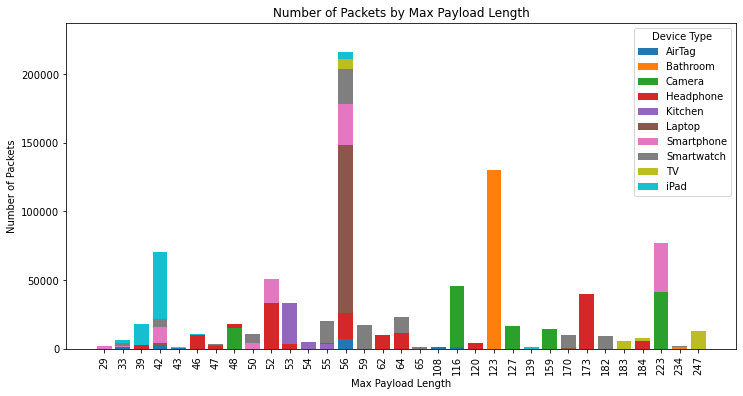

In [60]:
save_path = "Diagrams1/Number of Packets by Max Payload Length 1.png"
plot_derived_features(input_csv_file, 1000, 'Max Payload Length 1', 'Max Payload Length', save_path)

Sum Payload Length 1
57579     1306
123791    2219
123928    2220
129671    2320
Name: AirTag, dtype: int64
Sum Payload Length 1
43469        1044
5560290    129757
Name: Bathroom, dtype: int64
Sum Payload Length 1
70752       1474
302160      6295
336912      7019
651081     14196
741888     16152
2139008    41003
2234947    44375
Name: Camera, dtype: int64
Sum Payload Length 1
72925       1876
101383      1811
103899      2676
104645      1895
153909      3331
156306      3319
222557      4065
326483      5916
441662      9601
467804     10170
610543     11085
777618     15088
1490897    33334
1838313    39780
Name: Headphone, dtype: int64
Sum Payload Length 1
79112       1750
80795       1961
99717       1928
133690      2844
1304498    29744
Name: Kitchen, dtype: int64
Sum Payload Length 1
58408      1043
61208      1093
160160     2860
231448     4133
320096     5716
323288     5773
361088     6448
494256     8826
682528    12188
688800    12300
716016    12786
878584    15689
929

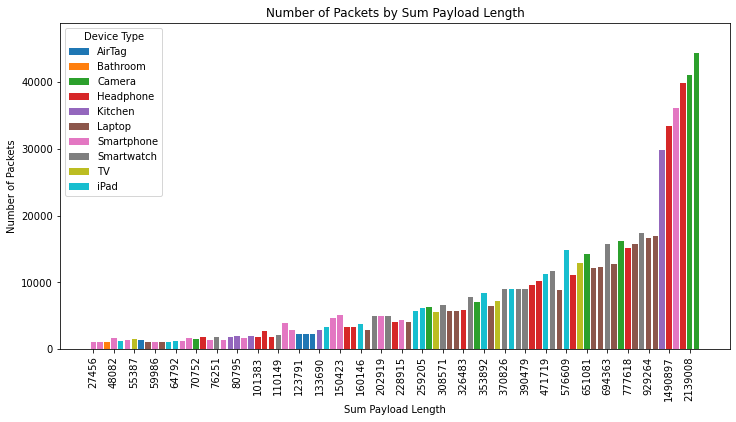

In [61]:
save_path = "Diagrams1/Number of Packets by Sum Payload Length 1.png"
plot_derived_features(input_csv_file, 1000, 'Sum Payload Length 1', 'Sum Payload Length', save_path, toothbrush='yes')

33     487
42    1433
44    1306
50       1
52       2
56    7124
Name: AirTag, dtype: int64
42      1044
43    129757
Name: Bathroom, dtype: int64
46    30348
48    14867
50    44375
52    41007
Name: Camera, dtype: int64
33       17
39     4552
42       10
45    33334
46    62882
47     3319
50        1
52    15088
55    22961
56     1830
Name: Headphone, dtype: int64
41     1961
44    29744
45     1750
47     2844
52     1928
Name: Kitchen, dtype: int64
33       255
42       610
52         1
56    122566
Name: Laptop, dtype: int64
29    11705
30     4653
33     1043
40     5017
41     2915
42     3391
48    36080
50     3866
52    13443
53     4314
56     8110
Name: Smartphone, dtype: int64
33     2301
37     4899
41    10872
42    20514
43    18063
44    20705
47     6567
48        1
51    17371
52       59
53     2070
56     1314
Name: Smartwatch, dtype: int64
37     1487
49    12968
51     7189
55     5513
Name: TV, dtype: int64
33     1726
39    14795
41     3330
42    44722
43 

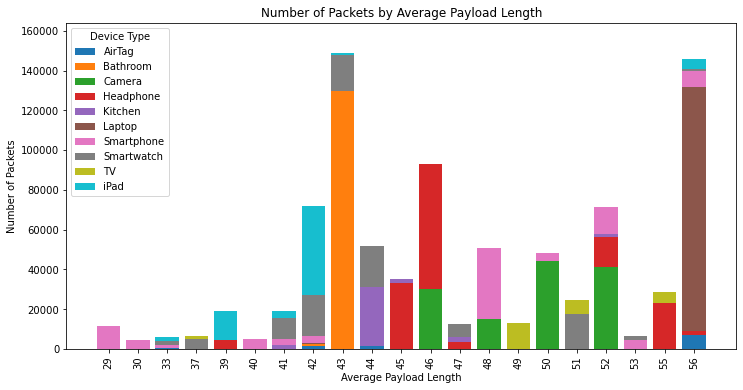

In [62]:
save_path = "Diagrams1/Number of Packets by Average Payload Length 1.png"
plot_derived_features(input_csv_file, 1000, 'Average Payload Length 1', 'Average Payload Length', save_path, rounding='0')

0    2198
2    6759
3    1306
Name: AirTag, dtype: int64
4     129757
19      1044
Name: Bathroom, dtype: int64
0    14857
5    44375
6    30348
8    41003
Name: Camera, dtype: int64
0    19823
1    13013
2    39780
4     1895
5    26173
6    43315
Name: Headphone, dtype: int64
1    29744
4     3678
7     1961
8     2844
Name: Kitchen, dtype: int64
0    124125
Name: Laptop, dtype: int64
0    27449
2     1073
3    13089
4     2915
5     9670
8    40394
Name: Smartphone, dtype: int64
0     28022
1      7864
4      1842
6      2070
7      4899
8      9071
10    11744
12    18022
13    20705
Name: Smartwatch, dtype: int64
3      5513
10     7189
11    12968
12     1487
Name: TV, dtype: int64
0    19682
1    31695
2    14704
3     3330
4     1241
Name: iPad, dtype: int64


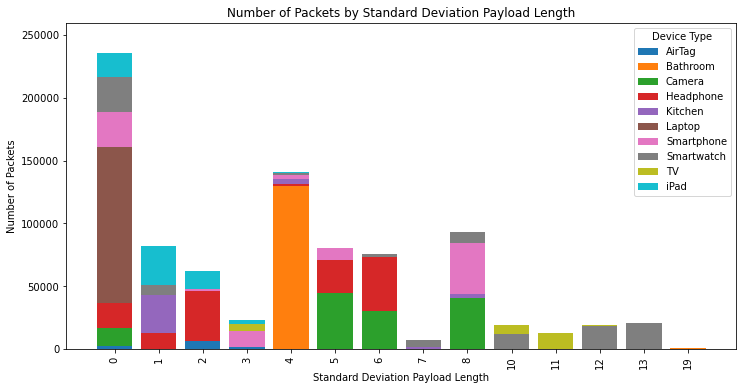

In [63]:
save_path = "Diagrams1/Number of Packets by Standard Deviation Payload Length 1.png"
plot_derived_features(input_csv_file, 1000, 'Standard Deviation Payload Length 1', 'Standard Deviation Payload Length', save_path, rounding='0')

0    2198
3    2320
5    2220
6    2219
7    1306
Name: AirTag, dtype: int64
14     129757
352      1044
Name: Bathroom, dtype: int64
0     14857
26    44375
32    16152
33    14196
71    41003
Name: Camera, dtype: int64
0     21634
1      7871
2      3331
3     39780
19     1895
22    11085
26    15088
31     4065
32     5916
34    33334
Name: Headphone, dtype: int64
2     29744
15     1928
19     1750
44     1961
72     2844
Name: Kitchen, dtype: int64
0    124125
Name: Laptop, dtype: int64
0     27449
2      1073
7      1639
8      3851
9      1404
11     6195
18     2915
20     5017
25     4653
65    36080
66     4314
Name: Smartphone, dtype: int64
0      28022
2       7864
20      1842
35      2070
48      4899
59      9071
104    11744
133     9030
144     8992
166    15791
175     4914
Name: Smartwatch, dtype: int64
7       5513
96      7189
120    12968
134     1487
Name: TV, dtype: int64
0     34477
1     16900
3      8470
6      6234
9      3330
13     1241
Name: iPad, dtype:

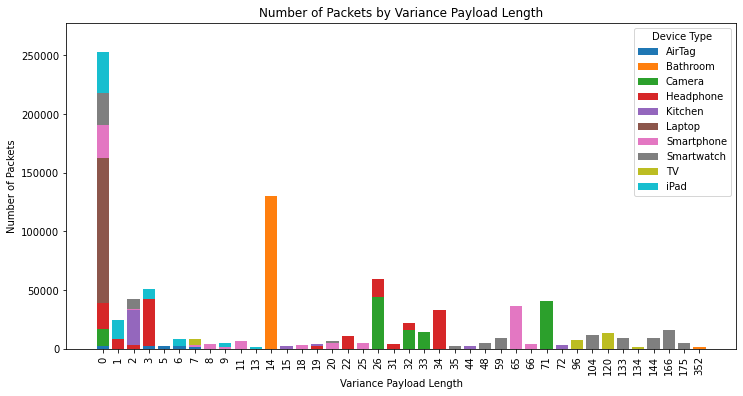

In [64]:
save_path = "Diagrams1/Number of Packets by Variance Payload Length 1.png"
plot_derived_features(input_csv_file, 1000, 'Variance Payload Length 1', 'Variance Payload Length', save_path, rounding='0')

Min Delta Time 1
91     1306
112       2
131    1246
132    2154
136    2320
138      92
149    2220
150    3100
260     259
Name: AirTag, dtype: int64
Min Delta Time 1
66    129757
78      1044
Name: Bathroom, dtype: int64
Min Delta Time 1
65     14788
71     41003
73     58571
74     16152
150        5
Name: Camera, dtype: int64
Min Delta Time 1
66      1811
68      3331
71     36653
72      1876
73     39780
75      2676
82      9601
101        1
105    10170
116    15088
132       16
149    23504
150        5
Name: Headphone, dtype: int64
Min Delta Time 1
66     1928
67     1961
71    29744
78     1750
80     2844
Name: Kitchen, dtype: int64
Min Delta Time 1
66      2860
67      8826
70      5773
75     16907
76     12188
78       318
87     25086
98      1093
107     5716
108    15689
116        1
121    16594
131     1900
132      651
141     6448
150      304
179     4133
260       59
Name: Laptop, dtype: int64
Min Delta Time 1
65      36080
71        450
77       1224
81       

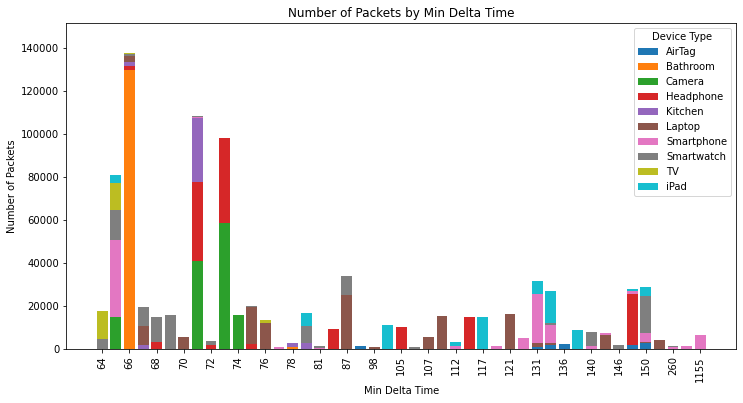

In [65]:
save_path = "Diagrams1/Number of Packets by Min Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Min Delta Time 1', 'Min Delta Time', save_path)

Max Delta Time 1
291762     2320
609932     2219
1126866    1306
1344692    2220
Name: AirTag, dtype: int64
Max Delta Time 1
32706       1044
142898    129757
Name: Bathroom, dtype: int64
Max Delta Time 1
11786      7019
11958      1474
13241      6295
91897     41003
96771     16152
112616    14196
653888    44375
Name: Camera, dtype: int64
Max Delta Time 1
31284      1876
36664      2676
69008     10170
88502      3331
105541     9601
105836     3319
105956     1811
148621    39780
197157    33334
206808    15088
222639     1895
279447     5916
377864    11085
881241     4065
Name: Headphone, dtype: int64
Max Delta Time 1
28937      2844
31240      1961
40219      1928
43504      1750
148940    29744
Name: Kitchen, dtype: int64
Max Delta Time 1
101244       1093
105807       5773
106688       1043
107893       4133
108835      16594
109405      12188
200355       6448
206655      16907
207903       5716
208518      12786
209740       2860
305374      15689
703206       8826
67052093 

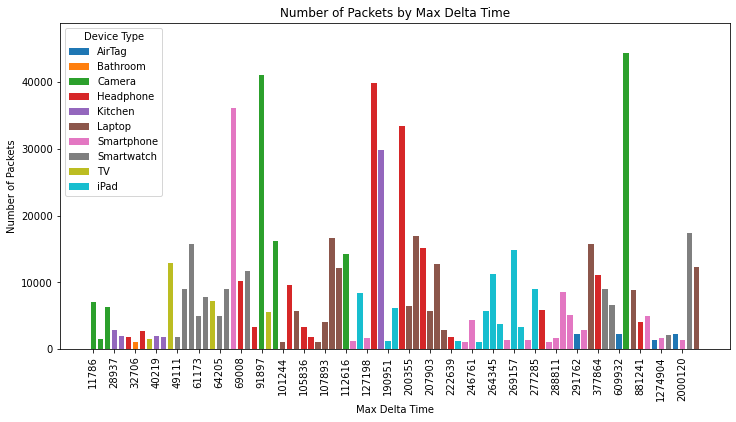

In [66]:
save_path = "Diagrams1/Number of Packets by Max Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Max Delta Time 1', 'Max Delta Time', save_path, toothbrush='yes')

Sum of Delta Time 1
89523645     1306
128353802    2320
307323337    2219
615437756    2220
Name: AirTag, dtype: int64
Sum of Delta Time 1
5705773        1044
694620385    129757
Name: Bathroom, dtype: int64
Sum of Delta Time 1
1505076       1474
6084567       6295
6547070       7019
93178139     14196
95006337     16152
211428275    44375
221815864    41003
Name: Camera, dtype: int64
Sum of Delta Time 1
5151989       1876
6846339       2676
20212626      1811
27876701      1895
27953041      3331
43639264      9601
49757129      3319
52090591     10170
96746748      4065
148128210    15088
298154293     5916
349096076    33334
437634194    39780
597623608    11085
Name: Headphone, dtype: int64
Sum of Delta Time 1
3645714       1961
4437121       1750
4780598       2844
5332222       1928
558369121    29744
Name: Kitchen, dtype: int64
Sum of Delta Time 1
14698686      1093
17549696      1043
50359934      2860
64922152      4133
97899396      5716
98133012      6448
102801788     5773


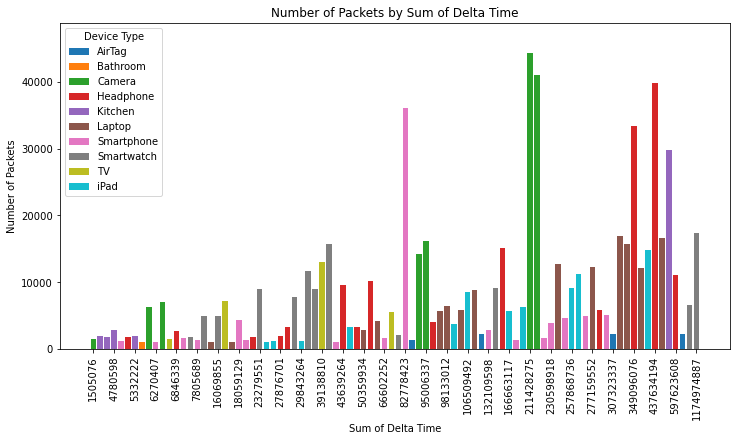

In [67]:
save_path = "Diagrams1/Number of Packets by Sum of Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Sum of Delta Time 1', 'Sum of Delta Time', save_path, toothbrush='yes')

55325     2320
68548     1306
138496    2219
277349    2220
Name: AirTag, dtype: int64
5353    129757
5465      1044
Name: Bathroom, dtype: int64
933      7019
967      6295
1021     1474
4765    44375
5410    41003
5882    16152
6564    14196
Name: Camera, dtype: int64
2558      2676
2746      1876
4545      9601
5122     10170
8392      3331
9818     15088
10473    33334
11001    39780
11161     1811
14711     1895
14992     3319
23806     4065
50398     5916
53913    11085
Name: Headphone, dtype: int64
1681      2844
1859      1961
2535      1750
2766      1928
18772    29744
Name: Kitchen, dtype: int64
13448     1093
14468     8826
15219     6448
15708     4133
16826     1043
17127     5716
17608     2860
17807     5773
18093    12786
18236    16907
21685    15689
22533    12300
29791    16594
29814    12188
Name: Laptop, dtype: int64
2294      36080
3953       1224
4186       4314
4234       1639
5844       1073
5851       1334
13732      1404
38273      1088
40170      1658
45321

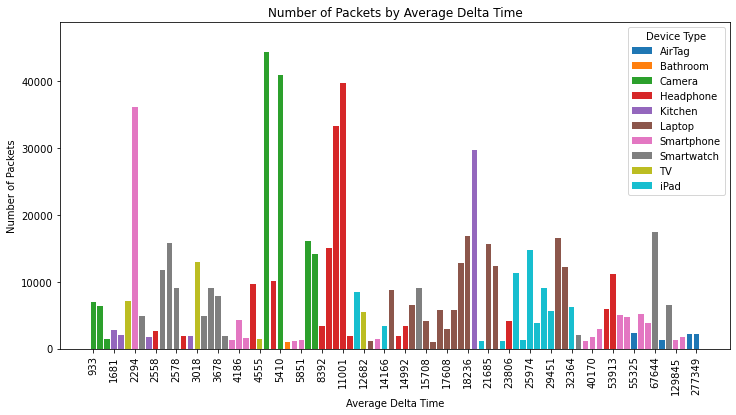

In [68]:
save_path = "Diagrams1/Number of Packets by Average Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Average Delta Time 1', 'Average Delta Time', save_path, toothbrush='yes', rounding='0')

89126     2320
115918    1306
226457    2219
492524    2220
Name: AirTag, dtype: int64
5103      1044
8945    129757
Name: Bathroom, dtype: int64
1026      7019
1106      6295
1208      1474
6218     44375
10604    41003
10634    16152
11894    14196
Name: Camera, dtype: int64
4464      2676
4682      1876
7847      9601
8699     10170
15856     3331
18905    15088
19618    33334
21139    39780
21179     1811
26738     3319
29702     1895
44191     4065
78423     5916
81439    11085
Name: Headphone, dtype: int64
3508      2844
3669      1961
4526      1750
4702      1928
31239    29744
Name: Kitchen, dtype: int64
24673      1093
26996      6448
27327      8826
28736      4133
29004      1043
29546      2860
30519      5716
30715      5773
30955     12786
31536     16907
36741     15689
44766     16594
45049     12188
605167    12300
Name: Laptop, dtype: int64
4699      36080
7761       1224
12415      1639
12460      4314
17283      1073
18666      1334
38403      1404
67839      1088


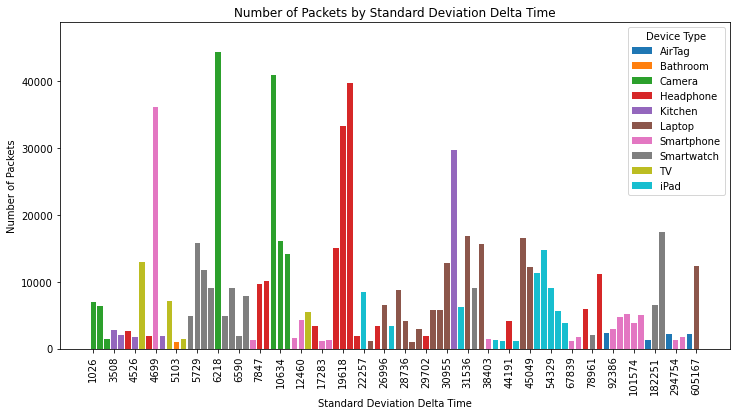

In [69]:
save_path = "Diagrams1/Number of Packets by Standard Deviation Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Standard Deviation Delta Time 1', 'Standard Deviation Delta Time', save_path, toothbrush='yes', rounding='0')

Variance Delta Time 1
7.943390e+09    2320
1.343687e+10    1306
5.128273e+10    2219
2.430000e+11    2220
Name: AirTag, dtype: int64
Variance Delta Time 1
26045491.42      1044
80013493.39    129757
Name: Bathroom, dtype: int64
Variance Delta Time 1
1.053146e+06     7019
1.222852e+06     6295
1.459542e+06     1474
3.866928e+07    44375
1.124376e+08    41003
1.130796e+08    16152
1.414736e+08    14196
Name: Camera, dtype: int64
Variance Delta Time 1
1.992511e+07     2676
2.192571e+07     1876
6.157518e+07     9601
7.566628e+07    10170
2.514104e+08     3331
3.573874e+08    15088
3.848654e+08    33334
4.468398e+08    39780
4.485294e+08     1811
7.149070e+08     3319
8.822173e+08     1895
1.952845e+09     4065
6.150141e+09     5916
6.632281e+09    11085
Name: Headphone, dtype: int64
Variance Delta Time 1
1.230606e+07     2844
1.346469e+07     1961
2.048772e+07     1750
2.211172e+07     1928
9.758549e+08    29744
Name: Kitchen, dtype: int64
Variance Delta Time 1
6.087417e+08     1093
7.287

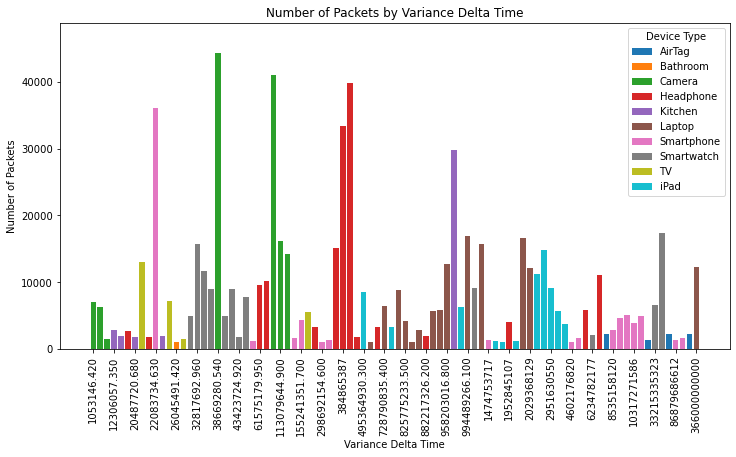

In [70]:
save_path = "Diagrams1/Number of Packets by Variance Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Variance Delta Time 1', 'Variance Delta Time', save_path, toothbrush='yes')

Packet Direction
backward      118
forward     16163
Name: AirTag, dtype: int64
Packet Direction
backward      7904
forward     122901
Name: Bathroom, dtype: int64
Packet Direction
backward     10441
forward     120166
Name: Camera, dtype: int64
Packet Direction
backward      1586
forward     143102
Name: Headphone, dtype: int64
Packet Direction
backward     1235
forward     37005
Name: Kitchen, dtype: int64
Packet Direction
backward         8
forward     127785
Name: Laptop, dtype: int64
Packet Direction
backward     7676
forward     94374
Name: Smartphone, dtype: int64
Packet Direction
backward    12539
forward     96043
Name: Smartwatch, dtype: int64
Packet Direction
backward     5774
forward     22350
Name: TV, dtype: int64
Packet Direction
backward      366
forward     74087
Name: iPad, dtype: int64


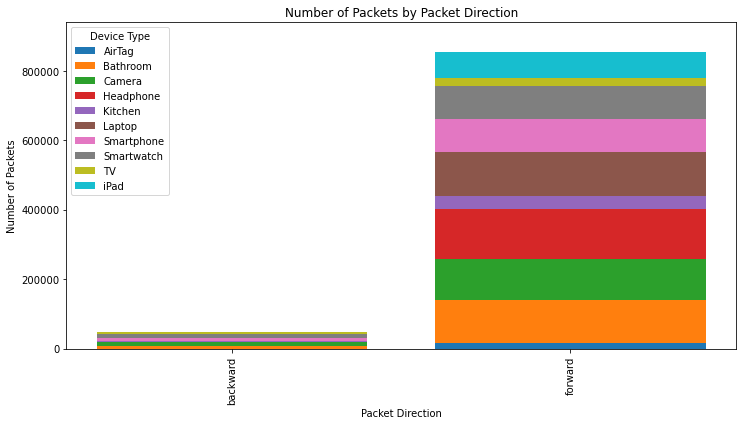

In [71]:
save_path = "Diagrams1/Number of Packets by Packet Direction.png"
plot_derived_features(input_csv_file, 1000, 'Packet Direction', 'Packet Direction', save_path)

Nr Forward Packets 1
1        213
1305    1306
2210    2219
2213    2220
2315    2320
Name: AirTag, dtype: int64
Nr Forward Packets 1
1              4
747         1044
122152    129757
Name: Bathroom, dtype: int64
Nr Forward Packets 1
1           24
1474      1474
6295      6295
7019      7019
12397    14196
14150    16152
36672    41003
42073    44375
Name: Camera, dtype: int64
Nr Forward Packets 1
1           53
1810      1811
1836      1895
1846      1876
2624      2676
3313      3319
3331      3331
3858      4065
5703      5916
9601      9601
10170    10170
10676    11085
14864    15088
32973    33334
39775    39780
Name: Headphone, dtype: int64
Nr Forward Packets 1
1           13
1590      1961
1720      1750
1884      1928
2375      2844
29423    29744
Name: Kitchen, dtype: int64
Nr Forward Packets 1
1          107
1043      1043
1093      1093
2860      2860
4133      4133
5716      5716
5773      5773
6448      6448
8826      8826
12188    12188
12300    12300
12786    12786
15

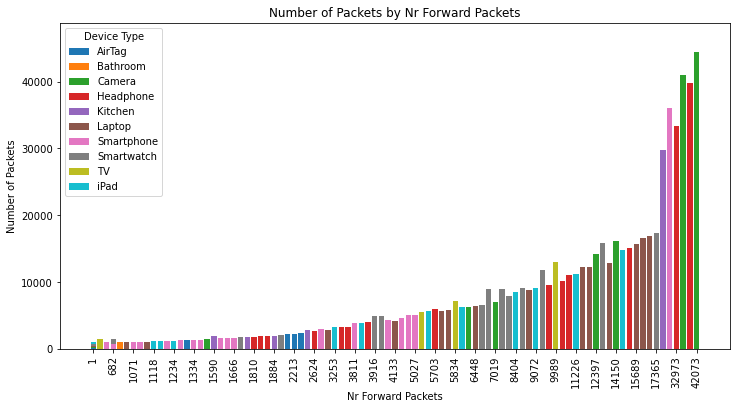

In [72]:
save_path = "Diagrams1/Number of Packets by Nr Forward Packets 1.png"
plot_derived_features(input_csv_file, 1000, 'Nr Forward Packets 1', 'Nr Forward Packets', save_path, toothbrush='yes')

Nr Backward Packets 1
0    3213
1    2385
2     683
3     119
4     936
5    2320
6     513
7    2220
9    2219
Name: AirTag, dtype: int64
Nr Backward Packets 1
0            1
2            3
297       1044
7605    129757
Name: Bathroom, dtype: int64
Nr Backward Packets 1
0       14871
1           2
3           8
1799    14196
2002    16152
2302    44375
4331    41003
Name: Camera, dtype: int64
Nr Backward Packets 1
0      23234
1       1903
2         96
5      39780
6       3319
30      1876
52      2676
59      1895
207     4065
213     5916
224    15088
361    33334
409    11085
Name: Headphone, dtype: int64
Nr Backward Packets 1
0         13
30      1750
44      1928
321    29744
371     1961
469     2844
Name: Kitchen, dtype: int64
Nr Backward Packets 1
0    126566
1       847
2       380
Name: Laptop, dtype: int64
Nr Backward Packets 1
0       29248
1          58
2        1106
3         556
5          22
6         877
10       3043
12        431
13        966
16       1088
40     

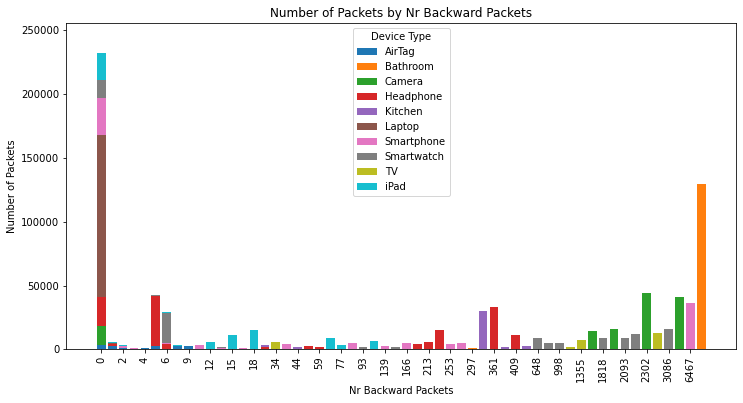

In [73]:
save_path = "Diagrams1/Number of Packets by Nr Backward Packets 1.png"
plot_derived_features(input_csv_file, 1000, 'Nr Backward Packets 1', 'Nr Backward Packets', save_path)

0.996    2219
0.997    2220
0.998    2320
0.999    1306
1.000    3213
Name: AirTag, dtype: int64
0.716      1044
0.941    129757
1.000         1
Name: Bathroom, dtype: int64
0.873    14196
0.876    16152
0.894    41003
0.948    44375
1.000    14871
Name: Camera, dtype: int64
0.949     4065
0.963    11085
0.964     5916
0.969     1895
0.981     2676
0.984     1876
0.985    15088
0.989    33334
0.998     3319
0.999     1811
1.000    39780
1.000    23234
Name: Headphone, dtype: int64
0.811     1961
0.835     2844
0.977     1928
0.983     1750
0.989    29744
1.000       13
Name: Kitchen, dtype: int64
1.0    126566
Name: Laptop, dtype: int64
0.821    36080
0.941     4314
0.944     5017
0.952     2915
0.964     4653
0.984     5107
0.985     1088
0.990     3851
0.993     1404
0.994     1639
0.998     1073
1.000    29248
Name: Smartphone, dtype: int64
0.767     8992
0.797     4914
0.799     9030
0.805    15791
0.807     4899
0.815    11744
0.917     1842
0.929     9071
0.955     2070
0.999    

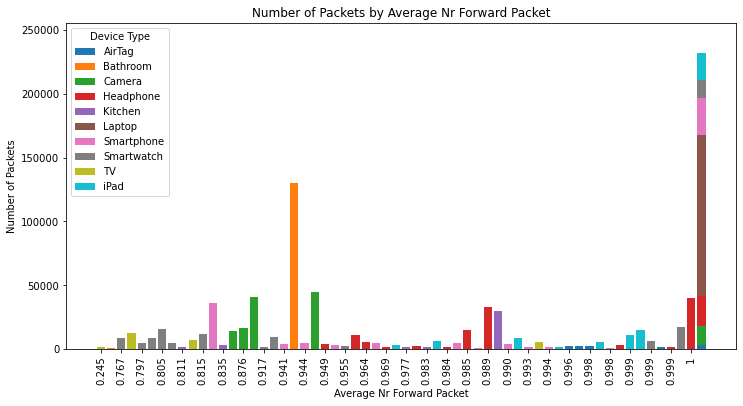

In [74]:
save_path = "Diagrams1/Number of Packets by Average Nr Forward Packet 1.png"
plot_derived_features(input_csv_file, 1000, 'Average Nr Forward Packet 1', 'Average Nr Forward Packet', save_path, rounding='yes')

0.000    3213
0.001    1306
0.002    2320
0.003    2220
0.004    2219
Name: AirTag, dtype: int64
0.000         1
0.059    129757
0.284      1044
Name: Bathroom, dtype: int64
0.000    14871
0.052    44375
0.106    41003
0.124    16152
0.127    14196
Name: Camera, dtype: int64
0.000    23234
0.000    39780
0.001     1811
0.002     3319
0.011    33334
0.015    15088
0.016     1876
0.019     2676
0.031     1895
0.036     5916
0.037    11085
0.051     4065
Name: Headphone, dtype: int64
0.000       13
0.011    29744
0.017     1750
0.023     1928
0.165     2844
0.189     1961
Name: Kitchen, dtype: int64
0.0    126566
Name: Laptop, dtype: int64
0.000    29248
0.002     1073
0.006     1639
0.007     1404
0.010     3851
0.015     1088
0.016     5107
0.036     4653
0.048     2915
0.056     5017
0.059     4314
0.179    36080
Name: Smartphone, dtype: int64
0.000    13834
0.000    17371
0.001     6567
0.045     2070
0.071     9071
0.083     1842
0.185    11744
0.193     4899
0.195    15791
0.201    

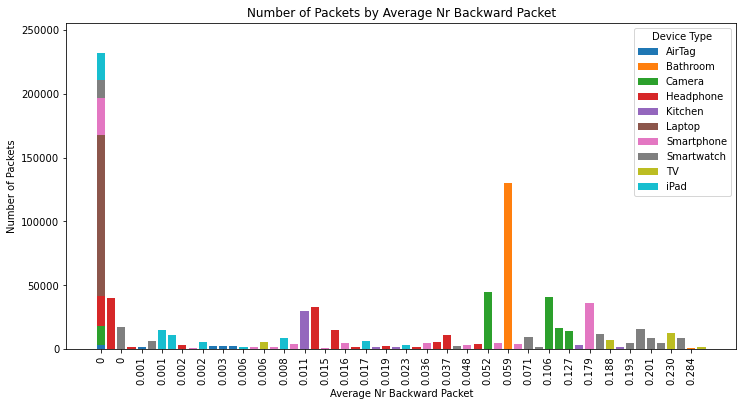

In [75]:
save_path = "Diagrams1/Number of Packets by Average Nr Backward Packet 1.png"
plot_derived_features(input_csv_file, 1000, 'Average Nr Backward Packet 1', 'Average Nr Backward Packet', save_path, rounding='yes')

Min Forward Delta Time 1
91     1306
94       88
112       2
131    1246
132    2154
136    2320
138      92
149    2220
150    3100
260     259
Name: AirTag, dtype: int64
Min Forward Delta Time 1
66     129757
94       1044
151         4
Name: Bathroom, dtype: int64
Min Forward Delta Time 1
65     14788
71     41003
73     58571
74     16152
150        1
Name: Camera, dtype: int64
Min Forward Delta Time 1
66      1811
68      3331
71     36653
72      1876
73     39780
75      2676
82      9601
101        1
105    10170
116    15088
132       16
150        5
151       26
334    11085
349     4065
355     1895
358     5916
Name: Headphone, dtype: int64
Min Forward Delta Time 1
66     1928
67     1961
71    29744
78     1750
80     2844
Name: Kitchen, dtype: int64
Min Forward Delta Time 1
66      2860
67      8826
70      5773
75     16907
76     12188
78       318
87     25086
98      1093
107     5716
108    15689
116        1
121    16594
131     1900
132      651
141     6448
150   

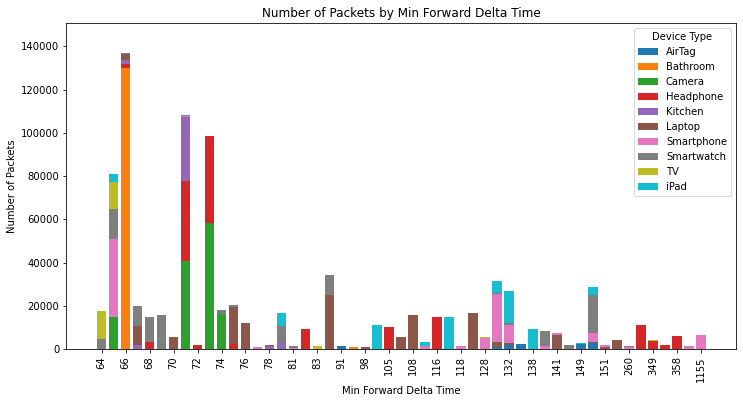

In [76]:
save_path = "Diagrams1/Number of Packets by Min Forward Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Min Forward Delta Time 1', 'Min Forward Delta Time', save_path)

Max Forward Delta Time 1
291762     2320
609932     2219
1126866    1306
1344692    2220
Name: AirTag, dtype: int64
Max Forward Delta Time 1
32706       1044
142898    129757
Name: Bathroom, dtype: int64
Max Forward Delta Time 1
11786      7019
11958      1474
13241      6295
91897     41003
96771     16152
112616    14196
653888    44375
Name: Camera, dtype: int64
Max Forward Delta Time 1
31284      1876
36664      2676
69008     10170
88502      3331
105541     9601
105836     3319
105956     1811
148621    39780
197157    33334
206808    15088
222639     1895
279447     5916
377864    11085
881241     4065
Name: Headphone, dtype: int64
Max Forward Delta Time 1
28937      2844
31240      1961
40219      1928
43504      1750
148940    29744
Name: Kitchen, dtype: int64
Max Forward Delta Time 1
101244       1093
105807       5773
106688       1043
107893       4133
108835      16594
109405      12188
200355       6448
206655      16907
207903       5716
208518      12786
209740       28

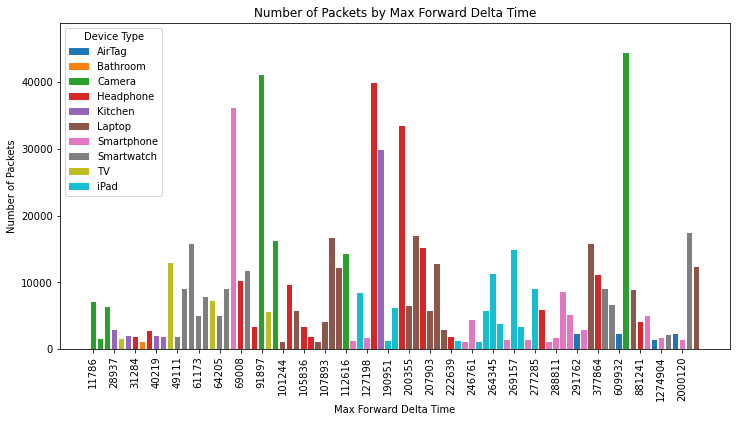

In [77]:
save_path = "Diagrams1/Number of Packets by Max Forward Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Max Forward Delta Time 1', 'Max Forward Delta Time', save_path, toothbrush='yes')

Sum Forward Delta Time 1
89522846     1306
128353048    2320
307321980    2219
615436702    2220
Name: AirTag, dtype: int64
Sum Forward Delta Time 1
4221511        1044
693309290    129757
Name: Bathroom, dtype: int64
Sum Forward Delta Time 1
1505076       1474
6084567       6295
6547070       7019
92904456     14196
94679951     16152
211065195    44375
221147005    41003
Name: Camera, dtype: int64
Sum Forward Delta Time 1
5095990       1876
6833744       2676
20212476      1811
27867862      1895
27953041      3331
43639264      9601
49756223      3319
52090591     10170
96715739      4065
148094536    15088
298122381     5916
349041827    33334
437633444    39780
597562297    11085
Name: Headphone, dtype: int64
Sum Forward Delta Time 1
3589261       1961
4432618       1750
4707022       2844
5325459       1928
558320173    29744
Name: Kitchen, dtype: int64
Sum Forward Delta Time 1
14698686      1093
17549696      1043
50359934      2860
64922152      4133
97899396      5716
98133012

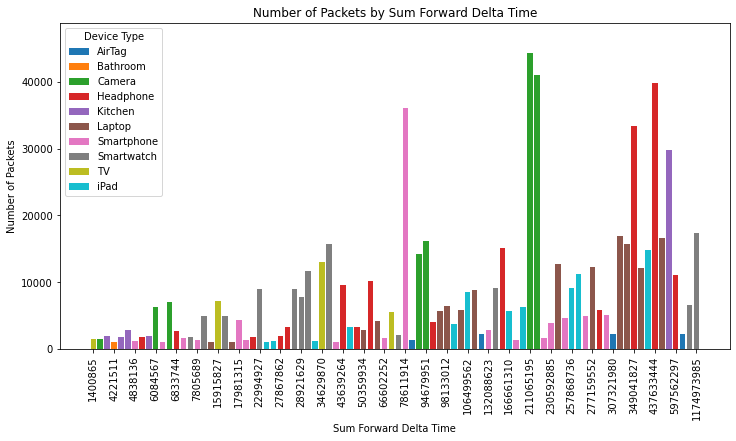

In [78]:
save_path = "Diagrams1/Number of Packets by Sum Forward Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Sum Forward Delta Time 1', 'Sum Forward Delta Time', save_path, toothbrush='yes')

55444     2320
68600     1306
139060    2219
278226    2220
Name: AirTag, dtype: int64
5651      1044
5676    129757
Name: Bathroom, dtype: int64
933      7019
967      6295
1021     1474
5017    44375
6031    41003
6691    16152
7494    14196
Name: Camera, dtype: int64
2604      2676
2761      1876
4545      9601
5122     10170
8392      3331
9963     15088
10586    33334
11003    39780
11167     1811
15018     3319
15179     1895
25075     4065
52275     5916
55972    11085
Name: Headphone, dtype: int64
1982      2844
2257      1961
2577      1750
2827      1928
18976    29744
Name: Kitchen, dtype: int64
13448     1093
14468     8826
15219     6448
15708     4133
16826     1043
17127     5716
17608     2860
17807     5773
18093    12786
18236    16907
21685    15689
22533    12300
29791    16594
29814    12188
Name: Laptop, dtype: int64
2655      36080
3953       1224
4259       1639
4428       4314
5851       1334
5854       1073
13830      1404
38842      1088
40170      1658
47582

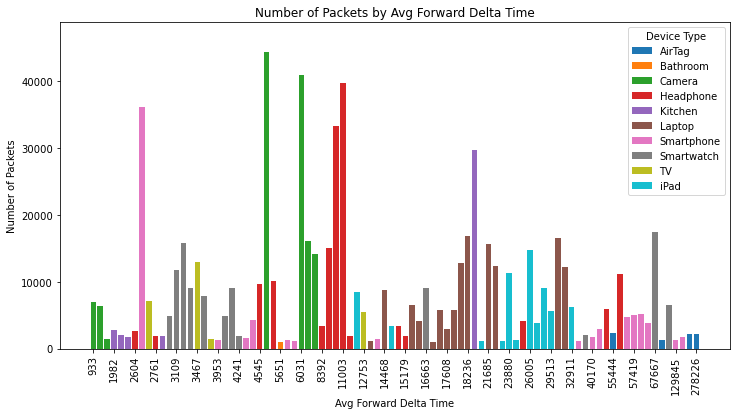

In [79]:
save_path = "Diagrams1/Number of Packets by Avg Forward Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Avg Forward Delta Time 1', 'Avg Forward Delta Time', save_path, toothbrush='yes', rounding='0')

89185     2320
115947    1306
226745    2219
493056    2220
Name: AirTag, dtype: int64
5249      1044
9121    129757
Name: Bathroom, dtype: int64
1026      7019
1106      6295
1208      1474
6290     44375
11049    41003
11125    16152
12457    14196
Name: Camera, dtype: int64
4495      2676
4678      1876
7847      9601
8699     10170
15856     3331
19009    15088
19695    33334
21140    39780
21183     1811
26754     3319
30059     1895
45011     4065
79259     5916
82289    11085
Name: Headphone, dtype: int64
3767      2844
3971      1961
4555      1750
4740      1928
31348    29744
Name: Kitchen, dtype: int64
24673      1093
26996      6448
27327      8826
28736      4133
29004      1043
29546      2860
30519      5716
30715      5773
30955     12786
31536     16907
36741     15689
44766     16594
45049     12188
605167    12300
Name: Laptop, dtype: int64
5002      36080
7761       1224
12449      1639
12798      4314
17297      1073
18666      1334
38523      1404
68183      1088


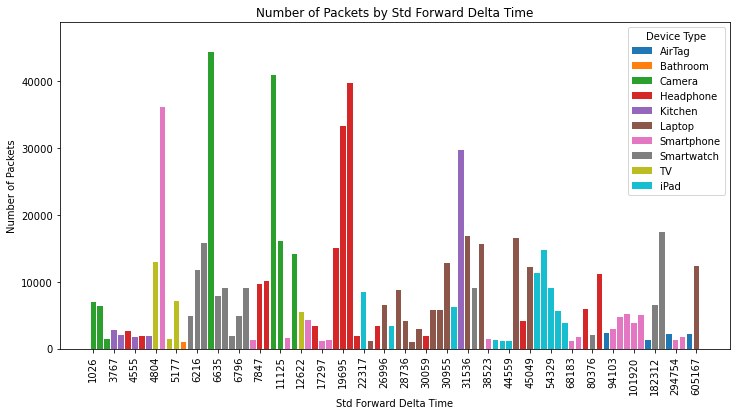

In [80]:
save_path = "Diagrams1/Number of Packets by Std Forward Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Std Forward Delta Time 1', 'Std Forward Delta Time', save_path, toothbrush='yes', rounding='0')

Var Forward Delta Time 1
7.953962e+09    2320
1.344365e+10    1306
5.141337e+10    2219
2.430000e+11    2220
Name: AirTag, dtype: int64
Var Forward Delta Time 1
27552443.93      1044
83190318.08    129757
Name: Bathroom, dtype: int64
Var Forward Delta Time 1
1.053146e+06     7019
1.222852e+06     6295
1.459542e+06     1474
3.955917e+07    44375
1.220698e+08    41003
1.237691e+08    16152
1.551736e+08    14196
Name: Camera, dtype: int64
Var Forward Delta Time 1
2.020883e+07     2676
2.188338e+07     1876
6.157518e+07     9601
7.566628e+07    10170
2.514104e+08     3331
3.613438e+08    15088
3.878998e+08    33334
4.468812e+08    39780
4.487103e+08     1811
7.158024e+08     3319
9.035469e+08     1895
2.026026e+09     4065
6.282041e+09     5916
6.771402e+09    11085
Name: Headphone, dtype: int64
Var Forward Delta Time 1
1.418707e+07     2844
1.576918e+07     1961
2.074424e+07     1750
2.246525e+07     1928
9.826777e+08    29744
Name: Kitchen, dtype: int64
Var Forward Delta Time 1
6.087417e

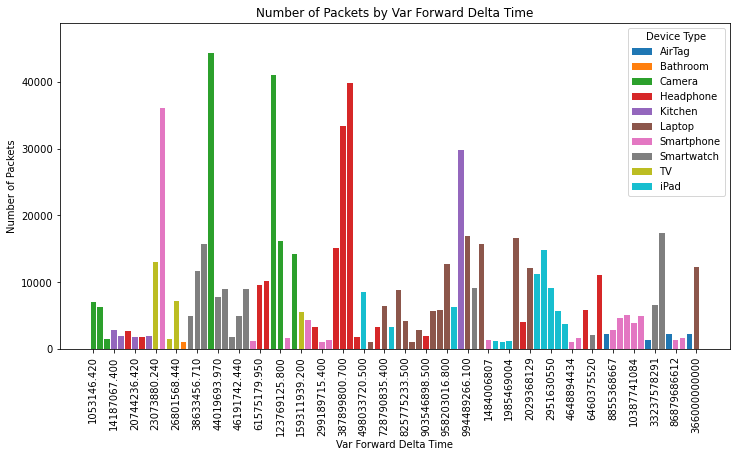

In [81]:
save_path = "Diagrams1/Number of Packets by Var Forward Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Var Forward Delta Time 1', 'Var Forward Delta Time', save_path, toothbrush='yes')

150    9969
151     685
799    1306
Name: AirTag, dtype: int64
78       1044
149    129757
151         3
Name: Bathroom, dtype: int64
99     14196
102    41003
147    16152
149    44375
150        4
151        6
Name: Camera, dtype: int64
149    71926
150    46148
151     3319
Name: Headphone, dtype: int64
85      2844
136     1928
148     1961
149    29744
150     1750
Name: Kitchen, dtype: int64
133    280
150    380
151    246
Name: Laptop, dtype: int64
66     36080
148     1073
149     6047
150    29489
151       97
Name: Smartphone, dtype: int64
67      8992
72      1842
78      4899
90     15791
105     9030
110     4914
133    11744
149    11205
150    19367
151     6603
Name: Smartwatch, dtype: int64
66       791
73     12968
76      1487
108     7189
150     5513
Name: TV, dtype: int64
149     9564
150    41952
151      314
Name: iPad, dtype: int64


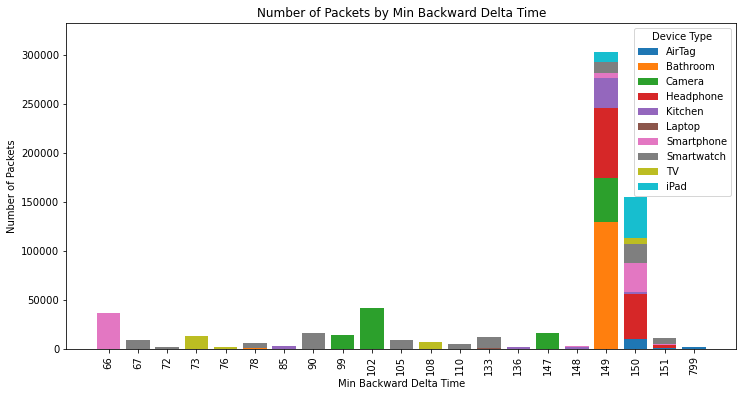

In [82]:
save_path = "Diagrams1/Number of Packets by Min Backward Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Min Backward Delta Time 1', 'Min Backward Delta Time', save_path, rounding='0')

151    5769
152    2320
799    1306
Name: AirTag, dtype: int64
151           3
21685      1044
28204    129757
Name: Bathroom, dtype: int64
151          6
152          4
664      14196
779      41003
6544     44375
20025    16152
Name: Camera, dtype: int64
149         26
150      42113
151      26280
152      48422
2245      2676
26324     1876
Name: Headphone, dtype: int64
151     1750
317     1928
607     1961
845    29744
923     2844
Name: Kitchen, dtype: int64
150    380
151    246
Name: Laptop, dtype: int64
149       1073
150       2281
151       3526
152      18370
258       1639
420       5017
19389     4314
39530    36080
Name: Smartphone, dtype: int64
149         18
151      17537
152       6572
695       2070
748       9030
887      15791
1128      4899
1470      9071
2458      4914
21837    11744
28308     1842
43174     8992
Name: Smartwatch, dtype: int64
2058      7189
14819     5513
34465    12968
39828     1487
Name: TV, dtype: int64
150        517
151      14571
152   

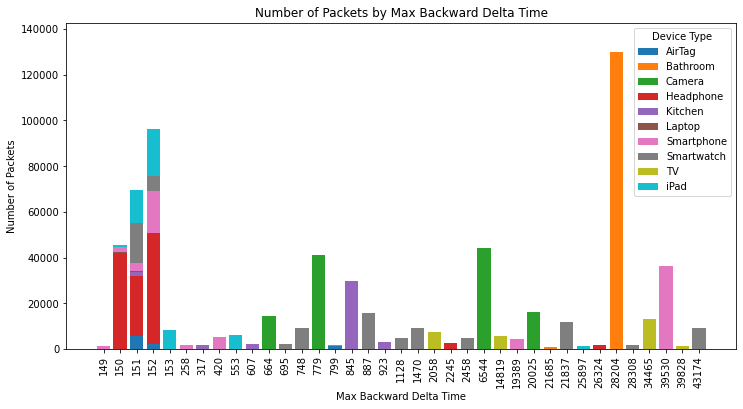

In [83]:
save_path = "Diagrams1/Number of Packets by Max Backward Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Max Backward Delta Time 1', 'Max Backward Delta Time', save_path, rounding='0')

Sum Backward Delta Time 1
0       3213
754     2320
799     1306
1054    2220
1357    2219
Name: AirTag, dtype: int64
Sum Backward Delta Time 1
0               1
1311095    129757
1484262      1044
Name: Bathroom, dtype: int64
Sum Backward Delta Time 1
0         14871
273683    14196
326386    16152
363080    44375
668859    41003
Name: Camera, dtype: int64
Sum Backward Delta Time 1
0        23234
150       1816
750      39780
906       3319
8839      1895
12595     2676
31009     4065
31912     5916
33674    15088
54249    33334
55999     1876
61311    11085
Name: Headphone, dtype: int64
Sum Backward Delta Time 1
0           13
4503      1750
6763      1928
48948    29744
56453     1961
73576     2844
Name: Kitchen, dtype: int64
Sum Backward Delta Time 1
0    126566
Name: Laptop, dtype: int64
Sum Backward Delta Time 1
0          29248
297         1073
1500        1404
1615        1639
2410        1088
6033        3851
12044       5107
20975       2915
25007       4653
42370       5017

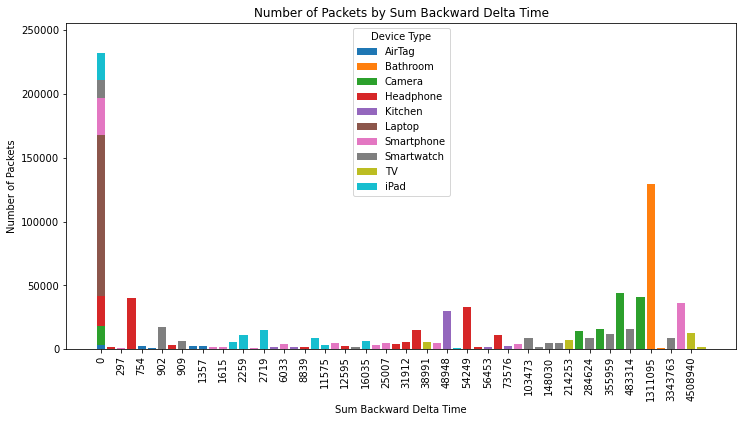

In [84]:
save_path = "Diagrams1/Number of Packets by Sum Backward Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Sum Backward Delta Time 1', 'Sum Backward Delta Time', save_path)

151    6976
799    1306
Name: AirTag, dtype: int64
151          3
172     129757
4998      1044
Name: Bathroom, dtype: int64
150        4
151        2
152    14196
154    41003
158    44375
163    16152
Name: Camera, dtype: int64
150     112979
151       3319
242       2676
1867      1876
Name: Headphone, dtype: int64
150     1750
152    31705
154     1928
157     2844
Name: Kitchen, dtype: int64
150    380
151    246
Name: Laptop, dtype: int64
148     1073
150     2281
151    17656
152     5017
162     1639
308     4314
644    36080
Name: Smartphone, dtype: int64
150     17371
151        10
152      6572
156      6969
157     24821
159      4914
160      9071
164     11744
740      1842
1598     8992
Name: Smartwatch, dtype: int64
158      7189
1147     5513
1514    12968
4788     1487
Name: TV, dtype: int64
150     12317
151     31695
154      6234
7429     1241
Name: iPad, dtype: int64


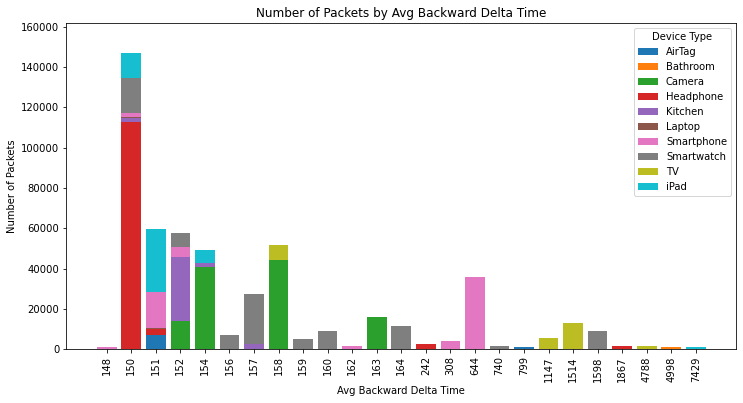

In [85]:
save_path = "Diagrams1/Number of Packets by Avg Backward Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Avg Backward Delta Time 1', 'Avg Backward Delta Time', save_path, toothbrush='yes', rounding='0')

0.000     215
0.441    2219
0.516     155
0.535    2220
0.837    2320
Name: AirTag, dtype: int64
0.000            3
689.499     129757
4693.474      1044
Name: Bathroom, dtype: int64
22.202     14196
38.931     41003
144.883    44375
445.256    16152
Name: Camera, dtype: int64
0.000       43099
0.482        5916
0.508        1895
0.521       33334
0.532       11085
0.535        4065
0.582       15088
0.707          96
380.783      2676
4955.933     1876
Name: Headphone, dtype: int64
0.305      1750
25.289     1928
31.972     1961
38.777    29744
57.009     2844
Name: Kitchen, dtype: int64
0.0    380
Name: Laptop, dtype: int64
0.000        2281
0.501        2915
0.525        5107
0.594        3851
0.707        1073
0.817        4653
0.885        1088
16.119       5017
33.909       1639
1506.599     4314
2304.277    36080
Name: Smartphone, dtype: int64
0.516       17371
0.548        6677
0.707           5
48.365       9030
51.430      15791
56.535       2070
58.298       4899
76.193     

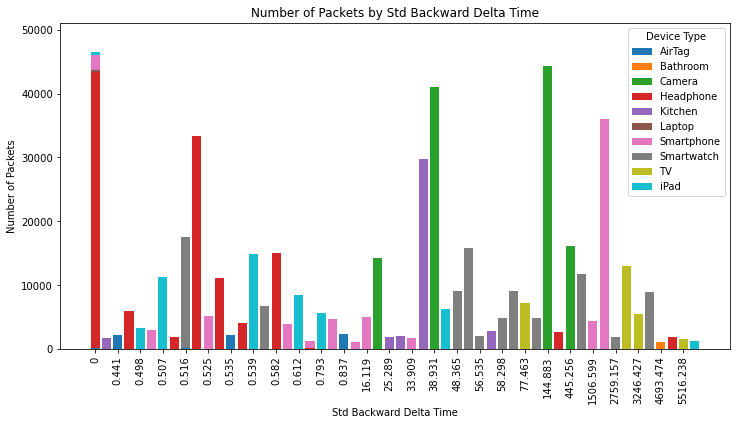

In [86]:
save_path = "Diagrams1/Number of Packets by Std Backward Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Std Backward Delta Time 1', 'Std Backward Delta Time', save_path, toothbrush='yes', rounding='yes')

Var Backward Delta Time 1
0.000000     215
0.194444    2219
0.266667     155
0.285714    2220
0.700000    2320
Name: AirTag, dtype: int64
Var Backward Delta Time 1
0.000000e+00         3
4.754090e+05    129757
2.202870e+07      1044
Name: Bathroom, dtype: int64
Var Backward Delta Time 1
492.926753       14196
1515.625539      41003
20991.179610     44375
198253.167500    16152
Name: Camera, dtype: int64
Var Backward Delta Time 1
0.000000e+00    43099
2.321729e-01     5916
2.577440e-01     1895
2.718067e-01    33334
2.825519e-01    11085
2.858215e-01     4065
3.388053e-01    15088
5.000000e-01       96
1.449957e+05     2676
2.456128e+07     1876
Name: Headphone, dtype: int64
Var Backward Delta Time 1
0.093103        1750
639.515328      1928
1022.224244     1961
1503.650584    29744
3250.038616     2844
Name: Kitchen, dtype: int64
Var Backward Delta Time 1
0.0    380
Name: Laptop, dtype: int64
Var Backward Delta Time 1
0.000000e+00     2281
2.506517e-01     2915
2.759494e-01     5107
3.

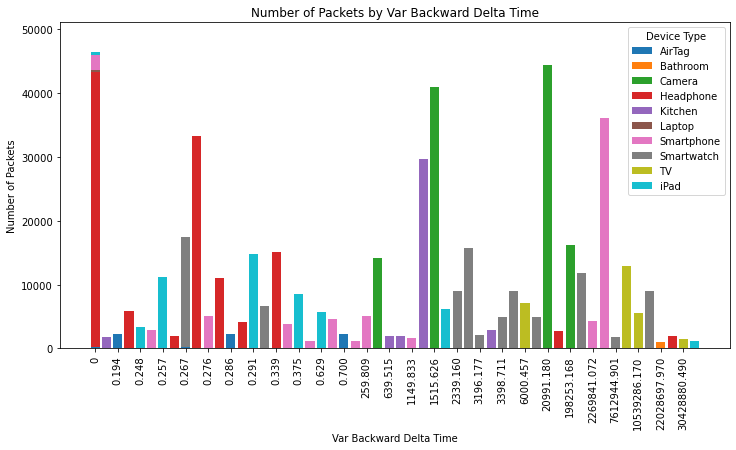

In [87]:
save_path = "Diagrams1/Number of Packets by Var Backward Delta Time 1.png"
plot_derived_features(input_csv_file, 1000, 'Var Backward Delta Time 1', 'Var Backward Delta Time', save_path, toothbrush='yes')

# DATA SPLITTING

In [88]:
X = joblib.load('csv 20 minutes/labeled2/features_final/together/X1.pkl')
y = joblib.load('csv 20 minutes/labeled2/features_final/together/y1.pkl')
X_train = joblib.load('csv 20 minutes/labeled2/features_final/together/X_train1.pkl')
X_test = joblib.load('csv 20 minutes/labeled2/features_final/together/X_test1.pkl')
y_train = joblib.load('csv 20 minutes/labeled2/features_final/together/y_train1.pkl')
y_test = joblib.load('csv 20 minutes/labeled2/features_final/together/y_test1.pkl')

In [89]:
# Print number of packets of training and test datasets
print("Total packets in training dataset:", len(X_train))
print("Total packets in test dataset:", len(X_test))

y_train_counts = pd.Series(y_train).value_counts()
y_test_counts = pd.Series(y_test).value_counts()
print("\nNumber of packets of each label in training dataset:")
print(y_train_counts)
print("\nNumber of packets of each label in test dataset:")
print(y_test_counts)

Total packets in training dataset: 721298
Total packets in test dataset: 180325

Number of packets of each label in training dataset:
Headphone     115716
Bathroom      104702
Camera        104519
Laptop        102357
Smartwatch     86436
Smartphone     81835
iPad           59618
Kitchen        30552
TV             22505
Airtag         13058
Name: label, dtype: int64

Number of packets of each label in test dataset:
Headphone     28972
Bathroom      26103
Camera        26088
Laptop        25436
Smartwatch    22146
Smartphone    20215
iPad          14835
Kitchen        7688
TV             5619
Airtag         3223
Name: label, dtype: int64


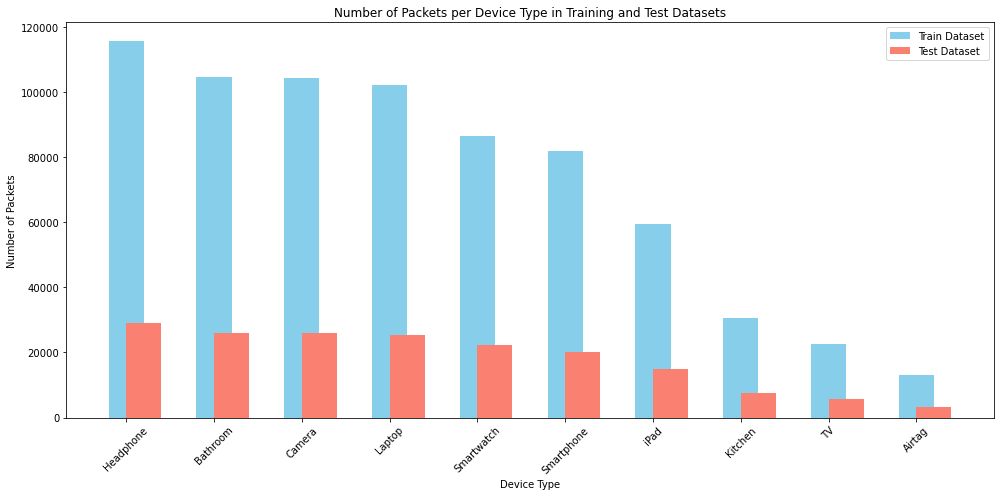

In [189]:
# Plot the number of packets for each label in the training and test datasets
labels = y_train_counts.index.union(y_test_counts.index)

labels = [label if label != 'Airtag' else 'AirTag' for label in labels]

train_counts = y_train_counts.reindex(labels, fill_value=0)
test_counts = y_test_counts.reindex(labels, fill_value=0)

x = range(len(labels))

plt.figure(figsize=(14, 7))

plt.bar(x, train_counts, width=0.4, label='Training Dataset', color='skyblue', align='center')
plt.bar(x, test_counts, width=0.4, label='Test Dataset', color='salmon', align='edge')

plt.xlabel('Device Type')
plt.ylabel('Number of Packets')
plt.title('Number of Packets per Device Type in Training and Test Datasets')
plt.xticks(x, labels, rotation=45)
plt.legend()

plt.tight_layout()
plt.savefig('Diagrams/Splitting.png', bbox_inches='tight')
plt.show()